# Load files

In [1]:
import numpy as np
import glob
import os
%pylab inline --no-import-all
plt.rc('font', family='serif', serif='Times', size=15)
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=20)
plt.rc('xtick.major', size=10)
plt.rc('ytick.major', size=10)
plt.rc('ytick', labelsize=20)
plt.rc('axes', labelsize=20)
plt.rc('figure', titlesize=25)
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['axes.linewidth'] = 2.
from astropy.io import fits

import logging as log
from crispy.tools.initLogger import getLogger
log = getLogger('main')
from crispy.tools.image import Image
os.chdir('/Users/mrizzo/IFS/crispy/crispy/WFIRST/')
from params import Params
import scipy as sp

par = Params()
par.hdr
cmap = 'inferno'  # 'gray_r'

Populating the interactive namespace from numpy and matplotlib


In [2]:
from crispy.tools.reduction import _add_row

lensX = 10
lensY = 10

from crispy.tools.locate_psflets import PSFLets
from crispy.tools.reduction import get_cutout
polychromeR = fits.open(par.wavecalDir + 'polychromeR%d.fits.gz' % (par.R))
psflets = polychromeR[0].data
# n_add = 1
# psflets = _add_row(psflets, n=n_add, dtype=np.float64)
# psflets[-n_add:] = 0
# psflets[-1, 4:-4, 4:-4] = 1

psftool = PSFLets()
lamlist = np.loadtxt(par.wavecalDir + "lamsol.dat")[:, 0]
allcoef = np.loadtxt(par.wavecalDir + "lamsol.dat")[:, 1:]

# lam in nm
psftool.geninterparray(lamlist, allcoef)

xlist = []
ylist = []
for lam in lamlist:
    _x, _y = psftool.return_locations(lam, allcoef, lensX, lensY)
    xlist += [_x]
    ylist += [_y]

im = Image(filename=par.wavecalDir + 'polychromeR%dstack.fits.gz' % (par.R))
subim, psflet_subarr, [x0, x1, y0, y1] = get_cutout(im, xlist, ylist, psflets)

crispy - INFO - Read data from HDU 0 of ..//ReferenceFiles/wavecalR50_770/polychromeR50stack.fits.gz


In [3]:
for i in range(psflet_subarr.shape[0]):
    psflet_subarr[i] /= np.sum(psflet_subarr[i])

Nbins = len(psflet_subarr)
print Nbins

18


In [4]:
polychromeR1px = fits.open(
    par.prefix+'/wavecalR50_770_9bins/polychromeR%d.fits.gz' % (par.R))
psflets = polychromeR1px[0].data
psftool = PSFLets()
lamlist = np.loadtxt(par.prefix+'/wavecalR50_770_9bins/lamsol.dat')[:, 0]
allcoef = np.loadtxt(par.prefix+'/wavecalR50_770_9bins/lamsol.dat')[:, 1:]

# lam in nm
psftool.geninterparray(lamlist, allcoef)

xlist = []
ylist = []
for lam in lamlist:
    _x, _y = psftool.return_locations(lam, allcoef, lensX, lensY)
    xlist += [_x]
    ylist += [_y]

im = Image(filename=par.prefix +
           '/wavecalR50_770_9bins/polychromeR%dstack.fits.gz' % (par.R))
subim_1px, psflet_subarr_1px, [x0, x1, y0,
                               y1] = get_cutout(im, xlist, ylist, psflets)
for i in range(psflet_subarr_1px.shape[0]):
    psflet_subarr_1px[i] /= np.sum(psflet_subarr_1px[i])
Nbins1px = len(psflet_subarr_1px)
print Nbins, Nbins1px

crispy - INFO - Read data from HDU 0 of ..//ReferenceFiles/wavecalR50_770_9bins/polychromeR50stack.fits.gz
18 9


# Extraction experiments

## Chi2 with 18 bins

18
[ 88.22975307 112.62760901  99.67347668 100.78732792 102.48307491
  64.73637604  99.51857475  81.68484592  86.20407385  75.98206668
  85.60276598 102.91834123  88.518189    95.17121769 107.68648936
  89.19106023 100.09226598 109.465563  ]


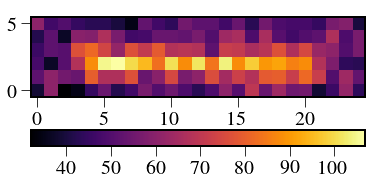

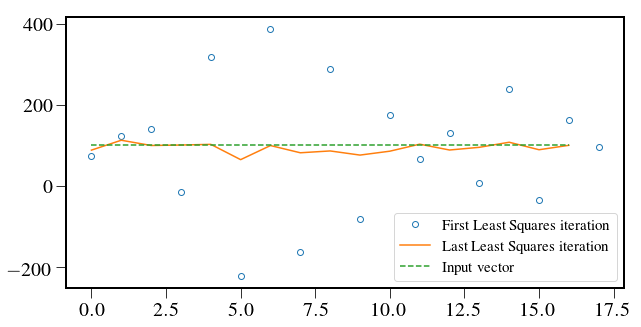

In [5]:
import scipy as sp
psflets_flat = np.reshape(psflet_subarr, (psflet_subarr.shape[0], -1))
A = psflets_flat.T
N = psflet_subarr.shape[0]
Niter = 5
print N
lstsq = np.zeros((N, Niter+1))
lstsq_notsmoothed = np.zeros((N, Niter+1))


pixnoise = 50
vect = np.ones(Nbins)*100
# vect[-1] = pixnoise
pimg = np.random.poisson(
    np.sum(psflet_subarr*vect[:, np.newaxis, np.newaxis], axis=0)+pixnoise)
plt.imshow(pimg, cmap=cmap)
plt.colorbar(orientation='horizontal')


# img = pimg-pixnoise
img = pimg-pixnoise
sumpix = np.sum(img)
lstsq[:, 0] = np.ones(N)*sumpix/float(N)
# lstsq[-1,0] = 0.
lstsq_notsmoothed[:, 0] = np.ones(N)*sumpix/float(N)
for i in range(Niter):
    prev = lstsq[:, i]
    variance = np.reshape(
#         np.sum(psflet_subarr*prev[:, np.newaxis, np.newaxis], axis=0), -1)
        np.sum(psflet_subarr*prev[:, np.newaxis, np.newaxis], axis=0)+pixnoise, -1)
    Ninv = np.diag(1./(variance+1e-10))
    Cinv = np.dot(A.T, np.dot(Ninv, A))
    C = np.linalg.inv(Cinv)
    Q = sp.linalg.sqrtm(Cinv)
    s = np.sum(Q, axis=0)
    R = Q/s[:, np.newaxis]
    x = np.reshape(img, -1)
    right = np.dot(A.T, np.dot(Ninv, x))
    f = np.dot(C, right)
    lstsq_notsmoothed[:, i+1] = f
    lstsq[:, i+1] = np.dot(R, f)
outvect = np.dot(R, vect)
plt.figure(figsize=(10, 5))
plt.plot(np.dot(np.linalg.inv(R),lstsq[:, 1]), linestyle='none', marker='o',
         markerfacecolor='none', label="First Least Squares iteration")
plt.plot(lstsq[:-1, -1], label="Last Least Squares iteration")
# plt.plot(lstsq_notsmoothed[:-1, -1],
#          label="Last Least Squares iteration, unsmoothed")
plt.plot(outvect[:-1], '--', label="Input vector")
plt.legend()
print lstsq[:, -1]

0.9767706182844462
0.9504078073539712


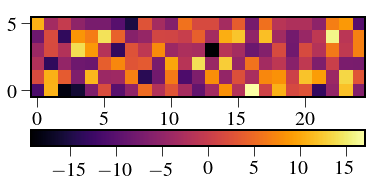

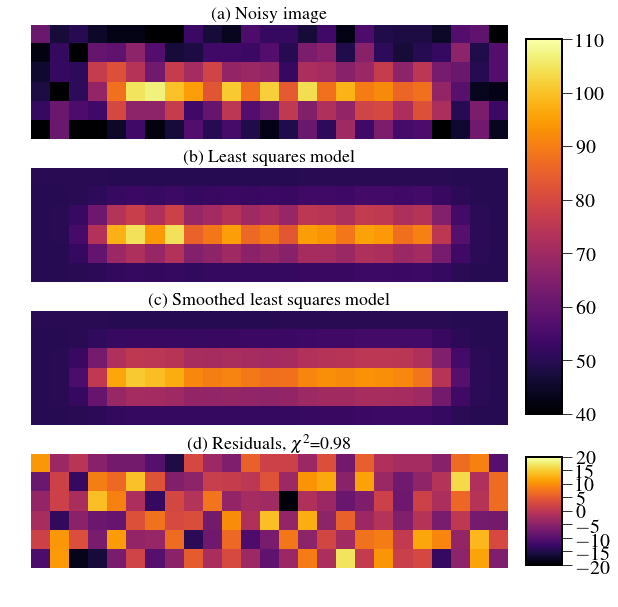

In [6]:
plt.figure()
final = lstsq[:, -1]
model = pixnoise+np.sum(psflet_subarr*final[:, np.newaxis, np.newaxis], axis=0)
model_notsmoothed = pixnoise + \
    np.sum(psflet_subarr*final[:, np.newaxis, np.newaxis], axis=0)
res = pimg-model
plt.imshow(res, cmap=cmap)
plt.colorbar(orientation='horizontal')

chi2 = np.sum(res**2/model)/np.prod(res.shape)
chi2_notsmoothed = np.sum((pimg)**2/model)/np.prod(res.shape)
print chi2

vmin=40
vmax=110

fig, axarr = plt.subplots(4, 1, figsize=(10, 10))
axarr[0].axis('off')
axarr[0].set_title('(a) Noisy image')
im = axarr[0].imshow(pimg, cmap=cmap, vmin=vmin, vmax=vmax)

axarr[2].imshow(model, cmap=cmap, vmin=vmin, vmax=vmax)
axarr[2].set_title('(c) Smoothed least squares model')
axarr[2].axis('off')
axarr[1].axis('off')
final = lstsq_notsmoothed[:, -1]
model_notsmoothed = pixnoise + \
    np.sum(psflet_subarr*final[:, np.newaxis, np.newaxis], axis=0)
chi2_notsmoothed = np.sum((pimg-model_notsmoothed) **
                          2/model_notsmoothed)/np.prod(res.shape)
print chi2_notsmoothed

axarr[1].imshow(model_notsmoothed, cmap=cmap, vmin=vmin, vmax=vmax)
axarr[1].set_title('(b) Least squares model')

axarr[3].axis('off')
axarr[3].set_title('(d) Residuals, $\chi^2$={:.2f}'.format(chi2))
im2 = axarr[3].imshow(res, cmap=cmap, vmin=-20, vmax=20)

fig.subplots_adjust(right=0.8, wspace=0.1, hspace=0.25)
cbar_ax = fig.add_axes([0.82, 0.34, 0.05, 0.52])
fig.colorbar(im, cax=cbar_ax)
cbar_ax = fig.add_axes([0.82, 0.13, 0.05, 0.15])
fig.colorbar(im2, cax=cbar_ax)

fig.savefig('/Users/mrizzo/Downloads/Microspectrum_Extraction.pdf',
            dpi=150, bbox_inches='tight')

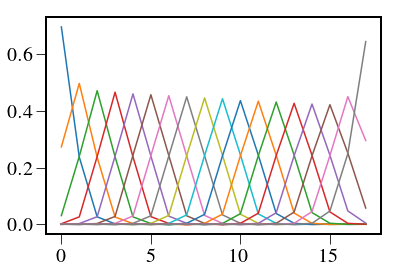

In [7]:
plt.plot(R)

## Chi2 with 9 bins

9


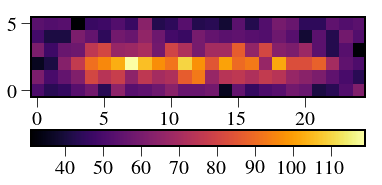

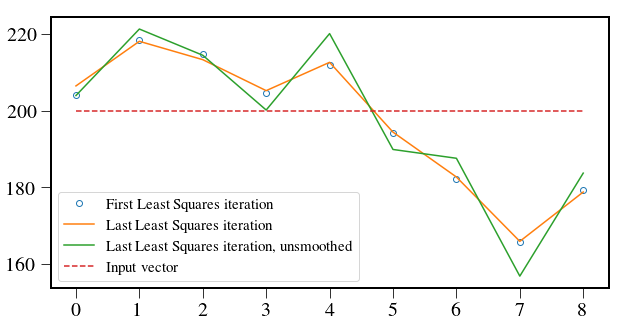

In [8]:
import scipy as sp
psflet_flat_1px = np.reshape(
    psflet_subarr_1px, (psflet_subarr_1px.shape[0], -1))
A1px = psflet_flat_1px.T
N1px = psflet_subarr_1px.shape[0]
Niter = 50
print N1px
lstsq1px = np.zeros((N1px, Niter+1))
lstsq_notsmoothed1px = np.zeros((N1px, Niter+1))


pixnoise = 50
vect = np.ones(N1px)*100*N/N1px
pimg = np.random.poisson(
    np.sum(psflet_subarr_1px*vect[:, np.newaxis, np.newaxis], axis=0)+pixnoise)
plt.imshow(pimg, cmap=cmap)
plt.colorbar(orientation='horizontal')


img = pimg-pixnoise
sumpix = np.sum(img)
lstsq1px[:, 0] = np.ones(N1px)*sumpix/float(N1px)/2
lstsq_notsmoothed1px[:, 0] = np.ones(N1px)*sumpix/float(N1px)/2
for i in range(Niter):
    prev = lstsq1px[:, i]
    variance = np.reshape(
        np.sum(psflet_subarr_1px*prev[:, np.newaxis, np.newaxis], axis=0)+pixnoise, -1)
    Ninv = np.diag(1./(variance+1e-10))
    Cinv = np.dot(A1px.T, np.dot(Ninv, A1px))
    C = np.linalg.inv(Cinv)
    Q = sp.linalg.sqrtm(Cinv)
    s = np.sum(Q, axis=0)
    R1px = Q/s[:, np.newaxis]
    x = np.reshape(img, -1)
    right = np.dot(A1px.T, np.dot(Ninv, x))
    f = np.dot(C, right)
    lstsq_notsmoothed1px[:, i+1] = f
    lstsq1px[:, i+1] = np.dot(R1px, f)
outvect1px = np.dot(R1px, vect)
plt.figure(figsize=(10, 5))
plt.plot(lstsq1px[:, 1], linestyle='none', marker='o',
         markerfacecolor='none', label="First Least Squares iteration")
plt.plot(lstsq1px[:, -1], label="Last Least Squares iteration")
plt.plot(lstsq_notsmoothed1px[:, -1],
         label="Last Least Squares iteration, unsmoothed")
plt.plot(outvect1px[:], '--', label="Input vector")
plt.legend()

1.000766629651905
0.9997280291962888


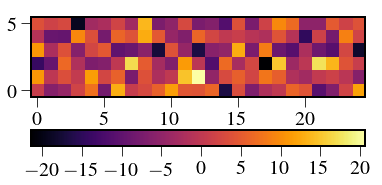

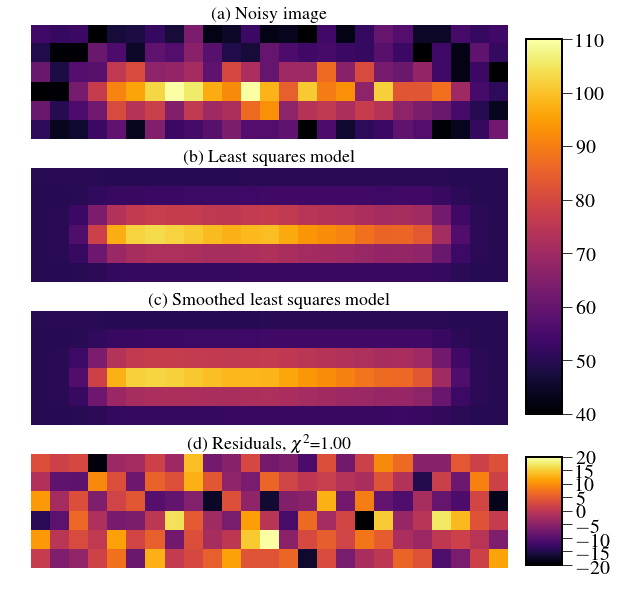

In [9]:
plt.figure()
final = lstsq1px[:, -1]
model = pixnoise+np.sum(psflet_subarr_1px*final[:, np.newaxis, np.newaxis], axis=0)
model_notsmoothed = pixnoise + \
    np.sum(psflet_subarr_1px*final[:, np.newaxis, np.newaxis], axis=0)
res = pimg-model
plt.imshow(res, cmap=cmap)
plt.colorbar(orientation='horizontal')

chi2 = np.sum(res**2/model)/np.prod(res.shape)
chi2_notsmoothed = np.sum((pimg)**2/model)/np.prod(res.shape)
print chi2

fig, axarr = plt.subplots(4, 1, figsize=(10, 10))
axarr[0].axis('off')
axarr[0].set_title('(a) Noisy image')
im = axarr[0].imshow(pimg, cmap=cmap, vmin=40, vmax=110)

axarr[2].imshow(model, cmap=cmap, vmin=40, vmax=110)
axarr[2].set_title('(c) Smoothed least squares model')
axarr[2].axis('off')
axarr[1].axis('off')
final = lstsq_notsmoothed1px[:, -1]
model_notsmoothed = pixnoise + \
    np.sum(psflet_subarr_1px*final[:, np.newaxis, np.newaxis], axis=0)
chi2_notsmoothed = np.sum((pimg-model_notsmoothed) **
                          2/model_notsmoothed)/np.prod(res.shape)
print chi2_notsmoothed

axarr[1].imshow(model_notsmoothed, cmap=cmap, vmin=40, vmax=110)
axarr[1].set_title('(b) Least squares model')

axarr[3].axis('off')
axarr[3].set_title('(d) Residuals, $\chi^2$={:.2f}'.format(chi2))
im2 = axarr[3].imshow(res, cmap=cmap, vmin=-20, vmax=20)

fig.subplots_adjust(right=0.8, wspace=0.1, hspace=0.25)
cbar_ax = fig.add_axes([0.82, 0.34, 0.05, 0.52])
fig.colorbar(im, cax=cbar_ax)
cbar_ax = fig.add_axes([0.82, 0.13, 0.05, 0.15])
fig.colorbar(im2, cax=cbar_ax)

fig.savefig('/Users/mrizzo/Downloads/Microspectrum_Extraction.pdf',
            dpi=150, bbox_inches='tight')

## Chi2 study

In [10]:
def extract(pimg,pixnoise,psflet_subarr):
    psflets_flat = np.reshape(psflet_subarr, (psflet_subarr.shape[0], -1))
    A = psflets_flat.T
    N = psflet_subarr.shape[0]
    Niter = 5
    lstsq = np.zeros((N, Niter+1))
    lstsq_notsmoothed = np.zeros((N, Niter+1))

    img = pimg-pixnoise
    sumpix = np.sum(img)
    lstsq[:, 0] = np.ones(N)*sumpix/float(N)
    lstsq_notsmoothed[:, 0] = np.ones(N)*sumpix/float(N)
    for i in range(Niter):
        prev = lstsq[:, i]
        variance = np.reshape(
            np.sum(psflet_subarr*prev[:, np.newaxis, np.newaxis], axis=0)+pixnoise, -1)
        Ninv = np.diag(1./(variance+1e-10))
        Cinv = np.dot(A.T, np.dot(Ninv, A))
        C = np.linalg.inv(Cinv)
        Q = sp.linalg.sqrtm(Cinv)
        s = np.sum(Q, axis=0)
        R = Q/s[:, np.newaxis]
        x = np.reshape(img, -1)
        right = np.dot(A.T, np.dot(Ninv, x))
        f = np.dot(C, right)
        lstsq_notsmoothed[:, i+1] = f
        lstsq[:, i+1] = np.dot(R, f)
    outvect = np.dot(R, vect)
    final = lstsq[:, -1]
    model = pixnoise+np.sum(psflet_subarr*final[:, np.newaxis, np.newaxis], axis=0)
    model_notsmoothed = pixnoise + \
        np.sum(psflet_subarr*final[:, np.newaxis, np.newaxis], axis=0)
    res = pimg-model
    chi2 = np.sum(res**2/model)/np.prod(res.shape)
    chi2_notsmoothed = np.sum((pimg)**2/model)/np.prod(res.shape)

    return outvect,lstsq,lstsq_notsmoothed,chi2,chi2_notsmoothed

### Test chi2 study function

In [11]:
pixnoise = 50
vect = np.ones(Nbins)*100
# vect[-1] = pixnoise
pimg = np.random.poisson(
    np.sum(psflet_subarr*vect[:, np.newaxis, np.newaxis], axis=0)+pixnoise)


In [12]:
outvect,lstsq,lstsq_notsmoothed,chi2,chi2_notsmoothed = extract(pimg,pixnoise,psflet_subarr)

In [13]:
print chi2

0.9305394573548837


In [14]:
outvect,lstsq,lstsq_notsmoothed,chi2,chi2_notsmoothed = extract(pimg,pixnoise,psflet_subarr)

## Study line function width

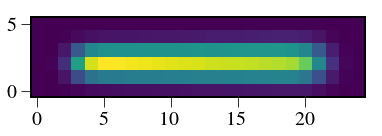

In [15]:
vect = np.ones(N)*100
plt.imshow(np.sum(psflet_subarr*vect[:, np.newaxis, np.newaxis], axis=0))

crispy - INFO - Reduced cube will have 18 wavelength bins


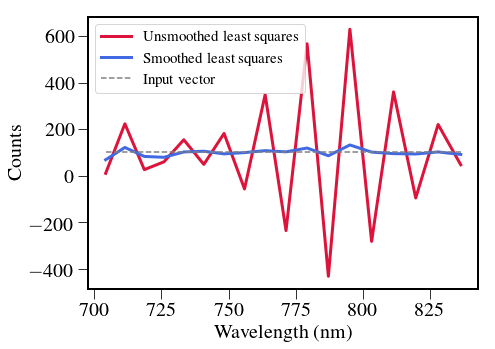

In [16]:
plt.figure(figsize=(7, 5))
from crispy.tools.reduction import calculateWaveList
lam_midpts, _ = calculateWaveList(par, method='lstsq')
# plt.plot(lstsq[:,1],linestyle='none',marker='o',markerfacecolor='none',label="First Least Squares iteration")
plt.plot(lam_midpts, lstsq_notsmoothed[:, -1],
         label="Unsmoothed least squares", color='crimson', lw=3)
plt.plot(lam_midpts, lstsq[:, -1],
         label="Smoothed least squares ", color='royalblue', lw=3)
plt.plot(lam_midpts, outvect[:], '--', label="Input vector", color='gray')
plt.legend()
plt.xlabel('Wavelength (nm)')
plt.ylabel('Counts')
plt.savefig('/Users/mrizzo/Downloads/Extracted_Microspectrum.pdf',
            dpi=150, bbox_inches='tight')

crispy - INFO - Reduced cube will have 18 wavelength bins
MSE= 0.007575818023357661


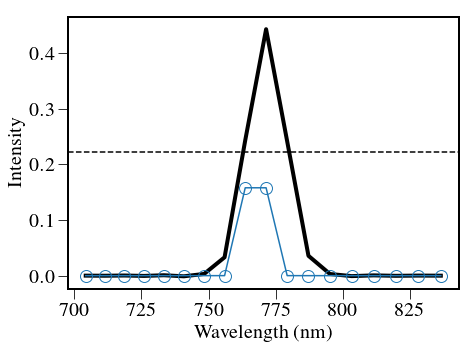

In [17]:
import pandas as pd
from crispy.tools.reduction import calculateWaveList
from scipy import signal
plt.figure(figsize=(7, 5))
pd.DataFrame(data=R)
lam_midpts, _ = calculateWaveList(par, method='lstsq')
plt.plot(lam_midpts, R[N/2, :], lw=4,
         label='Measured spectrograph resolution', color='k')
plt.plot(lam_midpts, 
         signal.gaussian(N, std=Nbins/11./2./2.35)*np.amax(R[N/2, :]), 
         label='Gaussian of FWHM=2', marker='o',
         markerfacecolor='none', markersize=12)
plt.axhline(y=np.amax(R[N/2, :])/2, color='k', linestyle='dashed')
# plt.text(610,0.23,"Half Maximum",fontsize=20)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')
# plt.title('Instrument line function')
plt.savefig('/Users/mrizzo/Downloads/Instrument_Line_Function.pdf',
            dpi=150, bbox_inches='tight')
MSE = np.sum((R[N/2, :]-signal.gaussian(N, std=19./11./2./2.35)
              * np.amax(R[N/2, :]))**2)/len(R[N/2, :])
print "MSE=", MSE
np.savetxt('/Users/mrizzo/Downloads/Rmatrix%d.txt' % (N), R)
# plt.plot(R[2,:],linestyle='dotted')
# plt.plot(R[-3,:],linestyle='dotted')
# plt.axvline(x=10,color='red',linestyle='dashed')
# plt.axvline(x=8,color='red',linestyle='dashed')
# plt.legend()

crispy - INFO - Reduced cube will have 9 wavelength bins
crispy - INFO - Reduced cube will have 18 wavelength bins


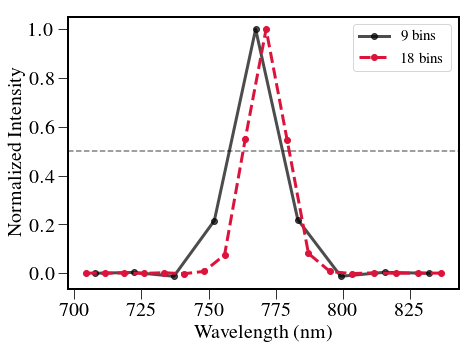

In [18]:
plt.figure(figsize=(7, 5))
lam_midpts, _ = calculateWaveList(par, method='lstsq', Nspec=Nbins1px+1)
# R11 = np.loadtxt('/Users/mrizzo/Downloads/Rmatrix11.txt')
plt.plot(lam_midpts, R1px[Nbins1px/2, :]/np.amax(R1px[Nbins1px/2, :]),
         lw=3, label='%d bins' % (Nbins1px), color='k', alpha=0.7, marker='o')
lam_midpts, _ = calculateWaveList(par, method='lstsq')
plt.plot(lam_midpts, R[Nbins/2, :]/np.amax(R[Nbins/2, :]), lw=3,
         linestyle='dashed', marker='o', label='%d bins' % (Nbins), color='crimson')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Normalized Intensity')
plt.axhline(y=0.5, color='k', linestyle='dashed', alpha=0.5)
plt.legend()
plt.savefig('/Users/mrizzo/Downloads/Instrument_Line_Function_Compare.pdf',
            dpi=150, bbox_inches='tight')

# SNR computation

In [19]:
def SNRcalc(vect, pixnoise, ntrials, psflets=psflet_subarr, Niter=3):
    psflets_flat = np.reshape(psflets, (psflets.shape[0], -1))
    A = psflets_flat.T
    N = psflets.shape[0]
    lstsq_notsmoothed = np.zeros((N, ntrials, Niter+1))
    lstsq = np.zeros((N, ntrials, Niter+1))
    varlstsq = np.zeros((N, ntrials, Niter+1))
    Rvect = np.zeros((N, ntrials, Niter+1))
    for j in range(ntrials):
        pimg = np.random.poisson(
            np.sum(psflets*vect[:, np.newaxis, np.newaxis], axis=0)+pixnoise)
        img = pimg-pixnoise
        sumpix = np.sum(img)
        lstsq[:, j, 0] = np.ones(N)*sumpix/float(N)/2
        for i in range(Niter):
            prev = lstsq[:, j, i]
            variance = np.reshape(
                np.sum(psflets*prev[:, np.newaxis, np.newaxis], axis=0)+pixnoise, -1)
            Ninv = np.diag(1./(variance+1e-10))
            Cinv = np.dot(A.T, np.dot(Ninv, A))
            C = np.linalg.inv(Cinv)
            Q = sp.linalg.sqrtm(Cinv)
            s = np.sum(Q, axis=0)
            R = Q/s[:, np.newaxis]
            x = np.reshape(img, -1)
            varlstsq[:, j, i+1] = 1./(s**2+1e-10)
            right = np.dot(A.T, np.dot(Ninv, x))
            f = np.dot(C, right)
            lstsq_notsmoothed[:, j, i+1] = f
            lstsq[:, j, i+1] = np.dot(R, f)
            Rvect[:, j, i+1] = np.dot(R, vect)
    return lstsq, lstsq_notsmoothed, varlstsq, Rvect

crispy - INFO - Reduced cube will have 18 wavelength bins


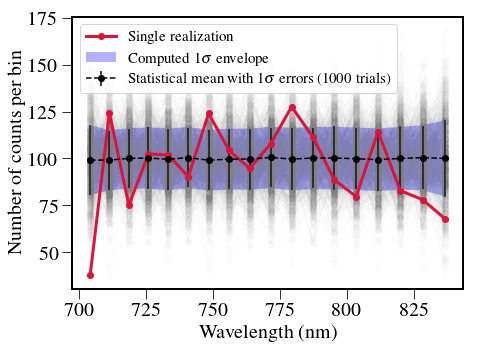

In [20]:
pixnoise = 50
vect = np.ones(N)*100
lstsq, lstsq_notsmoothed, varlstsq, Rvect = SNRcalc(
    vect, pixnoise, ntrials=1000)
lstsq = lstsq[:, :, -1]
varlstsq = varlstsq[:, :, -1]
Rvect = Rvect[:, :, -1]
lstsq_notsmoothed = lstsq_notsmoothed[:, :, -1]
np.savetxt('/Users/mrizzo/Downloads/lstsq%d.txt' % (N), lstsq)
np.savetxt('/Users/mrizzo/Downloads/varlstsq%d.txt' % (N), varlstsq)
np.savetxt('/Users/mrizzo/Downloads/Rvect%d.txt' % (N), Rvect)
np.savetxt('/Users/mrizzo/Downloads/lstsq_notsmoothed%d.txt' %
           (N), lstsq_notsmoothed)

vect1px = np.ones(N1px)*100*N/N1px
lstsq1px, lstsq_notsmoothed1px, varlstsq1px, Rvect1px = SNRcalc(vect1px, pixnoise, ntrials=1000,
                                                                psflets=psflet_subarr_1px, Niter=3)
lstsq1px = lstsq1px[:, :, -1]
varlstsq1px = varlstsq1px[:, :, -1]
Rvect1px = Rvect1px[:, :, -1]
lstsq_notsmoothed1px = lstsq_notsmoothed1px[:, :, -1]
np.savetxt('/Users/mrizzo/Downloads/lstsq%d.txt' % (N1px), lstsq1px)
np.savetxt('/Users/mrizzo/Downloads/varlstsq%d.txt' % (N1px), varlstsq1px)
np.savetxt('/Users/mrizzo/Downloads/Rvect%d.txt' % (N1px), Rvect1px)
np.savetxt('/Users/mrizzo/Downloads/lstsq_notsmoothed%d.txt' %
           (N1px), lstsq_notsmoothed1px)


lam_midpts, _ = calculateWaveList(par, method='lstsq')

plt.figure(figsize=(7, 5))
plt.plot(lam_midpts, lstsq, color='gray', alpha=0.01, marker='o')
plt.plot(lam_midpts, lstsq[:, -2], '-o',
         color='crimson', lw=3, label='Single realization')
plt.fill_between(lam_midpts, np.mean(lstsq, axis=1)-np.sqrt(varlstsq[:, -1]), np.mean(
    lstsq, axis=1)+np.sqrt(varlstsq[:, -1]), alpha=0.3, facecolor='blue', label='Computed 1$\sigma$ envelope')
plt.errorbar(lam_midpts, np.mean(lstsq, axis=1), yerr=np.std(lstsq, axis=1),
             label='Statistical mean with 1$\sigma$ errors (1000 trials)', color='k', marker='o', linestyle='dashed')
plt.legend(fontsize=15)
plt.ylabel('Number of counts per bin')
plt.xlabel(r'Wavelength (nm)')
plt.savefig('/Users/mrizzo/Downloads/Errorbars.pdf',
            dpi=150, bbox_inches='tight')

crispy - INFO - Reduced cube will have 9 wavelength bins
[199.32339898 198.8163702  199.22262081 199.73790274 199.3884315
 200.11734852 199.85042514 201.06260974 197.70168684]
crispy - INFO - Reduced cube will have 18 wavelength bins


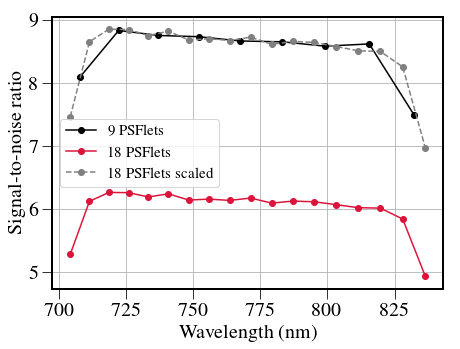

In [21]:
var9 = np.loadtxt('/Users/mrizzo/Downloads/varlstsq9.txt')
var18 = np.loadtxt('/Users/mrizzo/Downloads/varlstsq18.txt')
res9 = np.loadtxt('/Users/mrizzo/Downloads/lstsq9.txt')
res18 = np.loadtxt('/Users/mrizzo/Downloads/lstsq18.txt')
par.nchanperspec_lstsq = 1.
lam_midpts, _ = calculateWaveList(par, method='lstsq')
plt.figure(figsize=(7, 5))
print np.mean(res9, axis=1)
plt.plot(lam_midpts, np.mean(res9, axis=1) /
         np.sqrt(np.mean(var9, axis=1)), 'k', label='9 PSFlets', marker='o',)
par.nchanperspec_lstsq = 2.0
lam_midpts, _ = calculateWaveList(par, method='lstsq')
plt.plot(lam_midpts, np.mean(res18, axis=1)/np.sqrt(np.mean(var18,
                                                            axis=1)), 'crimson', marker='o', label='18 PSFlets')
plt.plot(lam_midpts, np.mean(res18, axis=1)/np.sqrt(np.mean(var18, axis=1)) *
         np.sqrt(2.), linestyle='dashed', marker='o', color='gray', label='18 PSFlets scaled')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Signal-to-noise ratio')
plt.legend()
plt.grid()
plt.savefig('/Users/mrizzo/Downloads/BinningImpactonSNR.pdf',
            dpi=150, bbox_inches='tight')

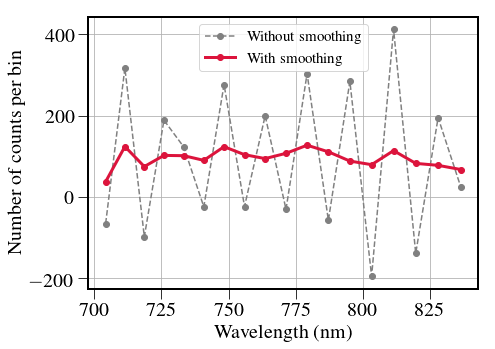

In [22]:
plt.figure(figsize=(7, 5))
plt.plot(lam_midpts,lstsq_notsmoothed[:, -2], color='gray', marker='o',
         linestyle='dashed', label='Without smoothing')
plt.plot(lam_midpts, lstsq[:, -2], '-o',
         color='crimson', lw=3, label='With smoothing')
plt.grid('on')
plt.legend()
plt.ylabel('Number of counts per bin')
plt.xlabel('Wavelength (nm)')
plt.savefig('/Users/mrizzo/Downloads/With-WithoutSmoothing.pdf',
            dpi=150, bbox_inches='tight')

# SNR and background pixels

9.753584840018352 3.029912983396491
18


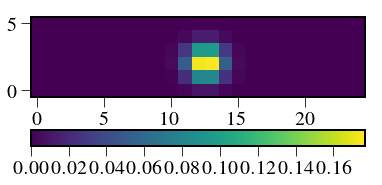

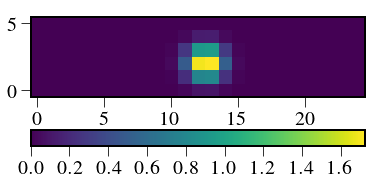

In [23]:
test = psflet_subarr[9].copy()
# test /= np.amax(test)
test /= np.sum(test)
print 1./np.sum(test**2), 1./np.sum((test[:, 12]/np.sum(test[:, 12]))**2)
plt.imshow(test)
plt.colorbar(orientation='horizontal')
plt.figure()
test /= np.sum(test**2)
plt.imshow(test)
plt.colorbar(orientation='horizontal')

print len(psflet_subarr)

In [24]:
mf = psflet_subarr[9].copy()
# test /= np.amax(test)
mf /= np.sum(mf)
coeff = np.sum(mf**3)/np.sum(mf**2)**2
print coeff
print 1./np.sum(mf**2)

1.3377190260618375
9.753584840018352


## Calculate sharpness

In [25]:
sharpnesses = np.zeros(len(psflet_subarr))
# mf = np.zeros_like(psflet_subarr)
for i in range(len(sharpnesses)):
    test = psflet_subarr[i].copy()
    test /= np.sum(test)
    test /= np.sum(test**2)
    sharpnesses[i]=np.sum(test)

In [26]:
print sharpnesses


[ 8.2500964   8.3827157   8.55445578  8.70555239  8.92835073  9.04639754
  9.20181541  9.39431075  9.58710431  9.75358484 10.03922781 10.09790323
 10.2760001  10.51529558 10.71989515 11.04464427 11.12225995 11.3315459 ]


The simulation to do here is the following:
1. Calculate background pixels for the central bin for many trials
2. Repeat for several sampling

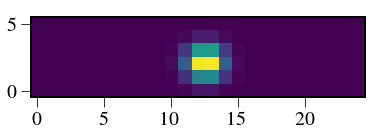

In [27]:
vect = np.ones(Nbins)*100
tot = np.sum(psflet_subarr*vect[:, np.newaxis, np.newaxis], axis=0)
plt.imshow(mf)

In [28]:
tot /= np.sum(tot)
Npix = 1./np.sum(tot**2)
mfnum = np.sum(tot**3)/np.sum(tot**2)**2
print mfnum
print Npix

1.2039180785442256
57.96948335953553


In [29]:
print Npix/Nbins
print (Npix-9.6)/(Nbins-2)

3.2205268533075295
3.0230927099709706


In [30]:
print 8.9/5.3
print 5.2/3.06

1.67924528302
1.69934640523


## Define function to calculate $\beta$

In [31]:
print Nbins


def SNRcalcBeta(vect, pixnoise, ntrials, Niter=3, psflets=psflet_subarr,verbose=True):
    psflets_flat = np.reshape(psflets, (psflets.shape[0], -1))
    A = psflets_flat.T
    N = psflets.shape[0]

    lstsq_notsmoothed = np.zeros((N, ntrials, Niter+1))
    lstsq = np.zeros((N, ntrials, Niter+1))
    varlstsq = np.zeros((N, ntrials, Niter+1))
    Rvect = np.zeros((N, ntrials, Niter+1))
    beta = np.zeros((N, ntrials, Niter+1))
    for j in range(ntrials):
        pimg = np.random.poisson(
            np.sum(psflets*vect[:, np.newaxis, np.newaxis], axis=0)+pixnoise)
        img = pimg-pixnoise
        sumpix = np.sum(img)
        lstsq[:, j, 0] = np.ones(N)*sumpix/float(N)
        if j % (max(ntrials/10, 1)) == 0 and verbose:
            print j, "/", ntrials
        for i in range(Niter):
            prev = lstsq[:, j, i]
            variance = np.reshape(
                np.sum(psflets*prev[:, np.newaxis, np.newaxis], axis=0)+pixnoise, -1)
            Ninv = np.diag(1./(variance+1e-10))
            Cinv = np.dot(A.T, np.dot(Ninv, A))
            C = np.linalg.inv(Cinv)
            Q = sp.linalg.sqrtm(Cinv)
            s = np.sum(Q, axis=0)
            R = Q/s[:, np.newaxis]
            x = np.reshape(img, -1)
            varlstsq[:, j, i+1] = 1./(s**2+1e-10)
            right = np.dot(A.T, np.dot(Ninv, x))
            f = np.dot(C, right)
            lstsq_notsmoothed[:, j, i+1] = f
            lstsq[:, j, i+1] = np.dot(R, f)
            Rvect[:, j, i+1] = np.dot(R, vect)
            beta[:, j, i+1] = (varlstsq[:, j, i+1]-lstsq[:, j, i+1])
    return lstsq, lstsq_notsmoothed, varlstsq, Rvect, beta

18


0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000
0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000
0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000


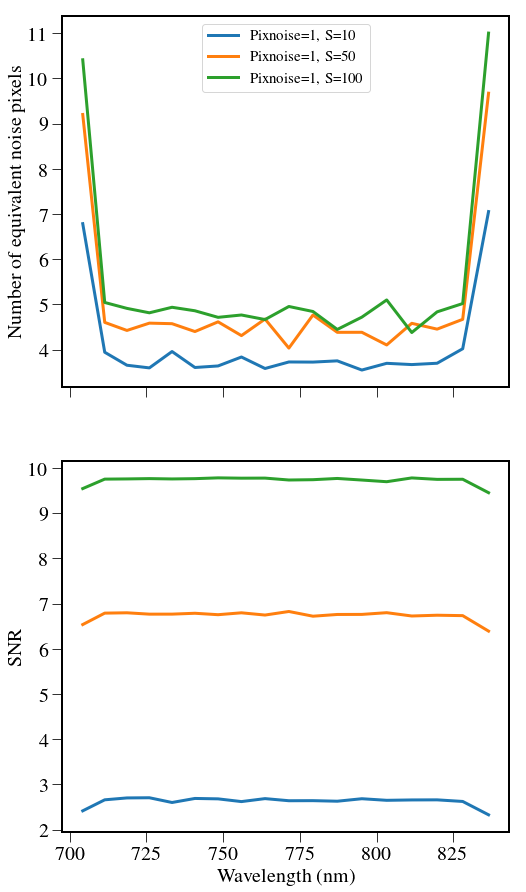

In [32]:
# Slist = [10.,50.,100,200,500,1000,10000]
# Slist = [2., 4., 8., 16., 32., 64., 128., 256.]
Slist = [10, 50, 100.]
ntrials = 1000
fig1, (ax1,ax2) = plt.subplots(2,figsize=(8,15),sharex=True)
for pxnoise in [1]:
    betalist = []
    SNR = []
    for S in Slist:
        vect = np.ones(N)*S
        lstsq, _, varlstsq, _, beta = SNRcalcBeta(
            vect, pxnoise, ntrials=ntrials)
        ax1.plot(lam_midpts,np.mean(beta[:, :, -1], axis=1)/(lam_midpts/lam_midpts[N//2]),
                 label='Pixnoise=%d, S=%d' % (pxnoise, S),lw=3)
        ax1.set_ylabel('Number of equivalent noise pixels')
        ax1.legend()
        ax2.plot(lam_midpts,np.mean(lstsq[:, :, -1]/np.sqrt(varlstsq[:, :, -1]),
                         axis=1), label='Pixnoise=%d, S=%d' % (pxnoise, S),lw=3)
#         ax2.plot(lam_midpts,np.sqrt(S))
#         ax2.errorbar(np.arange(N),np.mean(lstsq[:,:,-1],axis=1),yerr=np.std(lstsq[:,:,-1],axis=1),label='Statistical mean with 1$\sigma$ errors (1000 trials)',color='k',marker='o',linestyle='dashed')
        ax2.set_ylabel('SNR')
        ax2.set_xlabel('Wavelength (nm)')
        betalist.append(np.mean(beta[N/2, :, -1]))
        SNR.append(np.mean(lstsq[N/2, :, -1]/np.sqrt(varlstsq[N/2, :, -1])))

Text(0,0.5,u'Number of equivalent noise pixels')

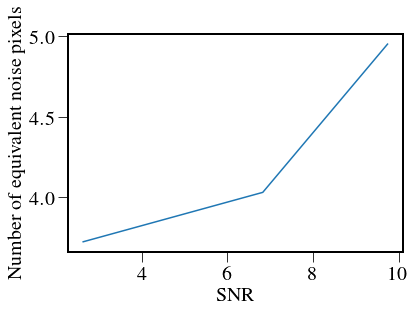

In [33]:
fig1.legend()
plt.figure()
plt.plot(SNR, betalist)
plt.xlabel('SNR')
plt.ylabel('Number of equivalent noise pixels')

## Study the background pixels as a function of background electrons per pixel

0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000
0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000
0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000
0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000
0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000
0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000


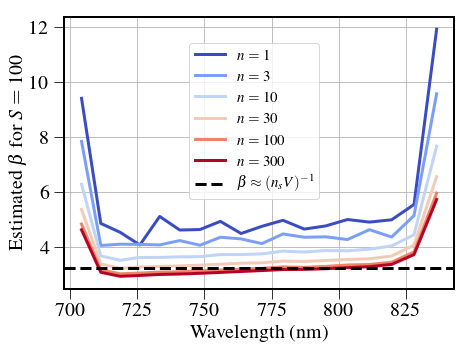

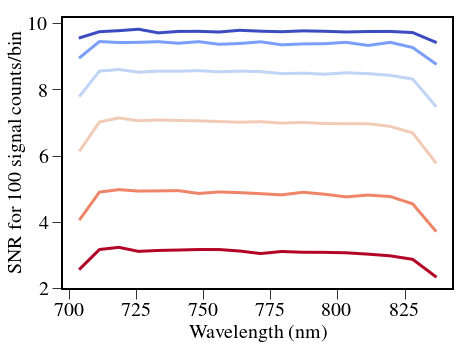

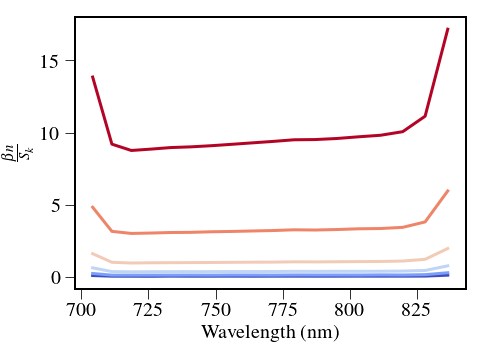

In [34]:
# Slist = [10.,50.,100,200,500,1000,10000]
Slist = [100]
# pxlist = [1.,10.,50,100,500,1000,2000,3000,4000,5000]
pxlist = [1, 3, 10, 30, 100, 300]
ntrials = 1000
fig1,ax1 = plt.subplots(figsize=(7,5))
fig2,ax2 = plt.subplots(figsize=(7,5))
fig3,ax3 = plt.subplots(figsize=(7,5))
ax1.set_ylabel(r'Estimated $\beta$ for $S=%d$' % Slist[0])
ax2.set_ylabel('SNR for %d signal counts/bin' % Slist[0])
ax3.set_ylabel(r'$\frac{\beta n}{S_k}$')
ax1.set_xlabel('Wavelength (nm)')
ax2.set_xlabel('Wavelength (nm)')
ax3.set_xlabel('Wavelength (nm)')
cmap = plt.get_cmap('coolwarm')
Ns = float(len(pxlist))
for S in Slist:
    SNR = []
    SNRlast = []
    SNR_stat = []
    betalist100 = []
    ratiolist100 = []
    betalast = []
    for i, pxnoise in enumerate(pxlist):
        vect = np.ones(N)*S*Nbins/N
        lstsq, _, varlstsq, _, beta = SNRcalcBeta(
            vect, pxnoise, ntrials=ntrials)
        ax1.plot(lam_midpts,np.mean(beta[:,:,-1]/pxnoise,axis=1),
                 label=r'$n=%d$'%(pxnoise),
                 color=cmap(float(i)/(Ns-1)),
                 lw=3
                )
        
        ax2.plot(lam_midpts,np.mean(lstsq[:,:,-1]/np.sqrt(varlstsq[:,:,-1]),axis=1),
                 label=r'$n=%d$'%(pxnoise),
                 color=cmap(float(i)/(Ns-1)),
                 lw=3
                )
#         ax2.plot(np.sqrt(S))
#         ax2.errorbar(np.arange(N),np.mean(lstsq[:,:,-1],axis=1),yerr=np.std(lstsq[:,:,-1],axis=1),label='Statistical mean with 1$\sigma$ errors (1000 trials)',color='k',marker='o',linestyle='dashed')
        
        ax3.plot(lam_midpts,np.mean(beta[:,:,-1],axis=1)/S,
                 label=r'$n=%d$'%(pxnoise),
                 color=cmap(float(i)/(Ns-1)),
                 lw=3
                )
        
        
        betalist100.append(np.mean(beta[N/2, :, -1])/pxnoise)
        ratiolist100.append(np.mean(beta[N/2,:,-1])/S)
        
        SNR.append(np.mean(lstsq[N/2, :, -1]/np.sqrt(varlstsq[N/2, :, -1])))
        SNR_stat.append(np.mean(lstsq[N/2, :, -1]/np.std(lstsq[N/2, :, -1])))
        betalast.append(np.mean(beta[-1, :, -1]))
        SNRlast.append(np.mean(lstsq[-1, :, -1]/np.sqrt(varlstsq[-1, :, -1])))
ax1.axhline(Npix/N,label=r'$\beta\approx(n_sV)^{-1}$',color='k',linestyle = '--',lw=3)
fig1.legend(loc=(0.4,0.43))
ax1.grid('on')
fig1.savefig('/Users/mrizzo/Downloads/BetaEstimates.pdf',
            dpi=150, bbox_inches='tight')

0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000
0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000
0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000
0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000
0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000
0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000


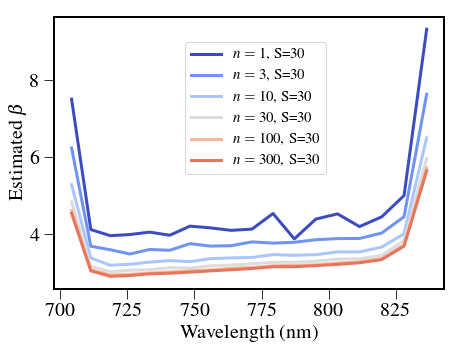

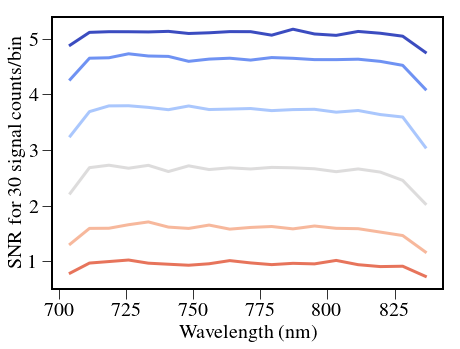

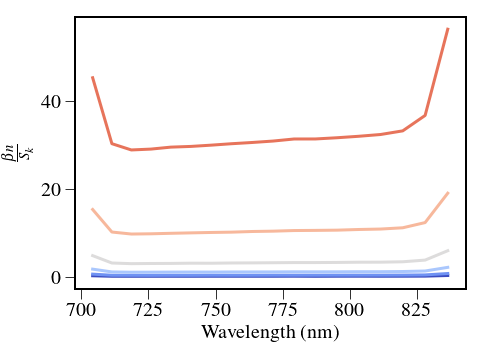

In [35]:
# Slist = [10.,50.,100,200,500,1000,10000]
Slist = [30]
# pxlist = [1.,10.,50,100,500,1000,2000,3000,4000,5000]
pxlist = [1, 3, 10, 30, 100, 300]
ntrials = 1000
fig1,ax1 = plt.subplots(figsize=(7,5))
fig2,ax2 = plt.subplots(figsize=(7,5))
fig3,ax3 = plt.subplots(figsize=(7,5))
ax1.set_ylabel(r'Estimated $\beta$')
ax2.set_ylabel('SNR for %d signal counts/bin' % Slist[0])
ax3.set_ylabel(r'$\frac{\beta n}{S_k}$')
ax1.set_xlabel('Wavelength (nm)')
ax2.set_xlabel('Wavelength (nm)')
ax3.set_xlabel('Wavelength (nm)')
cmap = plt.get_cmap('coolwarm')
Ns = float(len(pxlist))
for S in Slist:
    SNR = []
    SNRlast = []
    SNR_stat = []
    betalist30 = []
    ratiolist30 = []
    betalast = []
    for i, pxnoise in enumerate(pxlist):
        vect = np.ones(N)*S*Nbins/N
        lstsq, _, varlstsq, _, beta = SNRcalcBeta(
            vect, pxnoise, ntrials=ntrials)
        ax1.plot(lam_midpts,np.mean(beta[:,:,-1]/pxnoise,axis=1),
                 label=r'$n=%d$, S=%d'%(pxnoise,S),
                 color=cmap(float(i)/Ns),
                 lw=3
                )
        
        ax2.plot(lam_midpts,np.mean(lstsq[:,:,-1]/np.sqrt(varlstsq[:,:,-1]),axis=1),
                 label=r'$n=%d$, S=%d'%(pxnoise,S),
                 color=cmap(float(i)/Ns),
                 lw=3
                )
#         ax2.plot(np.sqrt(S))
#         ax2.errorbar(np.arange(N),np.mean(lstsq[:,:,-1],axis=1),yerr=np.std(lstsq[:,:,-1],axis=1),label='Statistical mean with 1$\sigma$ errors (1000 trials)',color='k',marker='o',linestyle='dashed')
        
        ax3.plot(lam_midpts,np.mean(beta[:,:,-1],axis=1)/S,
                 label=r'$n=%d$, S=%d'%(pxnoise,S),
                 color=cmap(float(i)/Ns),
                 lw=3
                )
        
        
        betalist30.append(np.mean(beta[N/2, :, -1])/pxnoise)
        ratiolist30.append(np.mean(beta[N/2,:,-1])/S)
        
        SNR.append(np.mean(lstsq[N/2, :, -1]/np.sqrt(varlstsq[N/2, :, -1])))
        SNR_stat.append(np.mean(lstsq[N/2, :, -1]/np.std(lstsq[N/2, :, -1])))
        betalast.append(np.mean(beta[-1, :, -1]))
        SNRlast.append(np.mean(lstsq[-1, :, -1]/np.sqrt(varlstsq[-1, :, -1])))
fig1.legend(loc=(0.4,0.5))

0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000
0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000
0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000
0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000
0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000
0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000


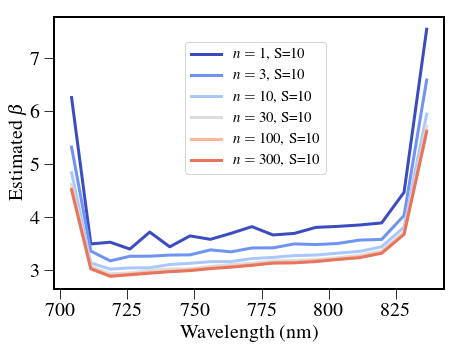

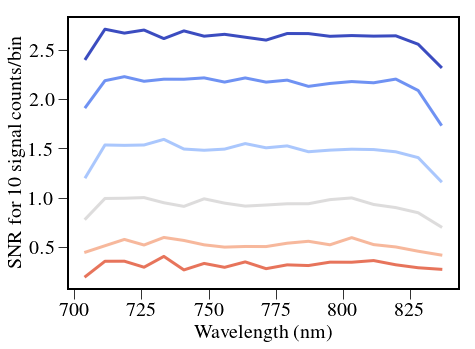

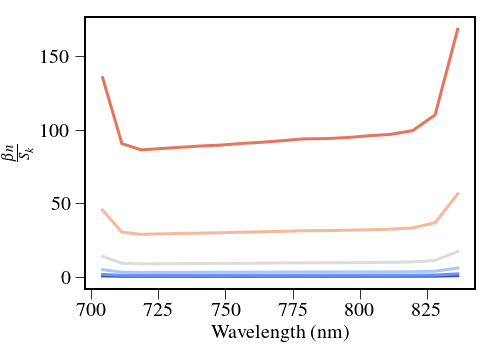

In [36]:
# Slist = [10.,50.,100,200,500,1000,10000]
Slist = [10]
# pxlist = [1.,10.,50,100,500,1000,2000,3000,4000,5000]
pxlist = [1, 3, 10, 30, 100, 300]
ntrials = 1000
fig1,ax1 = plt.subplots(figsize=(7,5))
fig2,ax2 = plt.subplots(figsize=(7,5))
fig3,ax3 = plt.subplots(figsize=(7,5))
ax1.set_ylabel(r'Estimated $\beta$')
ax2.set_ylabel('SNR for %d signal counts/bin' % Slist[0])
ax3.set_ylabel(r'$\frac{\beta n}{S_k}$')
ax1.set_xlabel('Wavelength (nm)')
ax2.set_xlabel('Wavelength (nm)')
ax3.set_xlabel('Wavelength (nm)')
cmap = plt.get_cmap('coolwarm')
Ns = float(len(pxlist))
for S in Slist:
    SNR = []
    SNRlast = []
    SNR_stat = []
    betalist10 = []
    ratiolist10 = []
    betalast = []
    for i, pxnoise in enumerate(pxlist):
        vect = np.ones(N)*S*Nbins/N
        lstsq, _, varlstsq, _, beta = SNRcalcBeta(
            vect, pxnoise, ntrials=ntrials)
        ax1.plot(lam_midpts,np.mean(beta[:,:,-1]/pxnoise,axis=1),
                 label=r'$n=%d$, S=%d'%(pxnoise,S),
                 color=cmap(float(i)/Ns),
                 lw=3
                )
        
        ax2.plot(lam_midpts,np.mean(lstsq[:,:,-1]/np.sqrt(varlstsq[:,:,-1]),axis=1),
                 label=r'$n=%d$, S=%d'%(pxnoise,S),
                 color=cmap(float(i)/Ns),
                 lw=3
                )
#         ax2.plot(np.sqrt(S))
#         ax2.errorbar(np.arange(N),np.mean(lstsq[:,:,-1],axis=1),yerr=np.std(lstsq[:,:,-1],axis=1),label='Statistical mean with 1$\sigma$ errors (1000 trials)',color='k',marker='o',linestyle='dashed')
        
        ax3.plot(lam_midpts,np.mean(beta[:,:,-1],axis=1)/S,
                 label=r'$n=%d$, S=%d'%(pxnoise,S),
                 color=cmap(float(i)/Ns),
                 lw=3
                )
        
        
        betalist10.append(np.mean(beta[N/2, :, -1])/pxnoise)
        ratiolist10.append(np.mean(beta[N/2,:,-1])/S)
        
        SNR.append(np.mean(lstsq[N/2, :, -1]/np.sqrt(varlstsq[N/2, :, -1])))
        SNR_stat.append(np.mean(lstsq[N/2, :, -1]/np.std(lstsq[N/2, :, -1])))
        betalast.append(np.mean(beta[-1, :, -1]))
        SNRlast.append(np.mean(lstsq[-1, :, -1]/np.sqrt(varlstsq[-1, :, -1])))
fig1.legend(loc=(0.4,0.5))

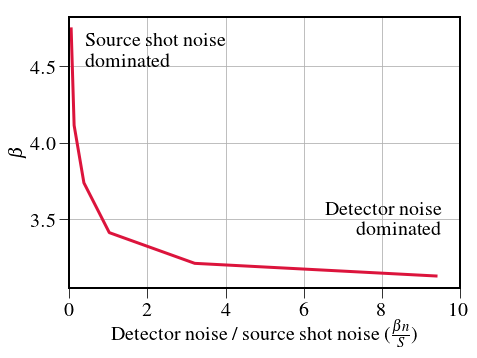

In [37]:
plt.figure(figsize=(7,5))
plt.plot(ratiolist100,betalist100,lw=3,color='crimson')
# plt.plot(ratiolist30,betalist30,lw=3,linestyle='none',marker='d',markersize=10,alpha=0.5)
# plt.plot(ratiolist10,betalist10,lw=3,linestyle='none',marker='p',markersize=10,alpha=0.5)
plt.xlabel(r'Detector noise / source shot noise ($\frac{\beta n}{S}$)')
plt.ylabel(r'$\beta$')
plt.grid('on')

plt.xlim([0,10])
# plt.annotate('Detector noise\n dominated', xy=(15, 3.5), xytext=(7, 3.5),
#             arrowprops=dict(facecolor='black', shrink=0.05),
#              verticalalignment='middle',
#              fontsize=20
#             )

plt.text(9.5, 3.4,'Detector noise\n dominated',fontsize=20,horizontalalignment='right')
plt.text(0.4, 4.5,'Source shot noise\n dominated',fontsize=20,horizontalalignment='left')
plt.savefig('/Users/mrizzo/Downloads/Beta_vs_ratio.pdf',
            dpi=150, bbox_inches='tight')

3.2205268533075295


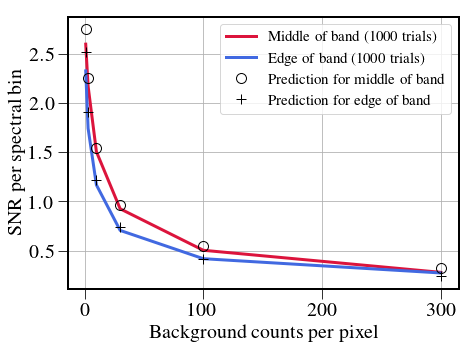

In [38]:
plt.figure(figsize=(7, 5))
plt.plot(pxlist, SNR, label='Middle of band (%d trials)' %
         ntrials, color='crimson', lw=3)
# plt.plot(pxlist,SNR_stat,label='Statistical SNR (%d trials)'%ntrials)
plt.plot(pxlist, SNRlast, label='Edge of band (%d trials)' %
         ntrials, color='royalblue', lw=3)
plt.plot(pxlist, Slist[0]/(np.sqrt(Slist[0]+Npix/Nbins*np.array(pxlist))),
         label='Prediction for middle of band', linestyle='none', marker='o', markersize=10, markerfacecolor='none', color='k')
plt.plot(pxlist, Slist[0]/(np.sqrt(Slist[0]+Npix/Nbins*1.8*np.array(pxlist))),
         label='Prediction for edge of band', linestyle='none', marker='+', markersize=10, markerfacecolor='none', color='k')
plt.xlabel('Background counts per pixel')
plt.ylabel('SNR per spectral bin')
plt.grid('on')
plt.legend()
plt.savefig('/Users/mrizzo/Downloads/BackgroundPixels.pdf',
            dpi=150, bbox_inches='tight')
print Npix/N

[2.5983484055794652, 2.171949547753151, 1.5054956449206376, 0.9251971434728228, 0.5036071919993254, 0.27929706887735617]
[2.75027182 2.25522972 1.5392766  0.96847676 0.54877776 0.32006628]
3.162277660168379


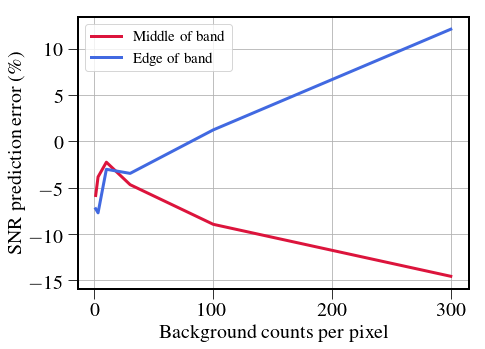

In [39]:
plt.figure(figsize=(7, 5))
plt.plot(pxlist, (SNR-Slist[0]*Nbins/N/(np.sqrt(Slist[0]*Nbins/N+Npix/N*np.array(pxlist))))/SNR*100.,
         label='Middle of band', color='crimson', lw=3)
plt.plot(pxlist, (SNRlast-Slist[0]*Nbins/N/(np.sqrt(Slist[0]*Nbins/N+Npix/N*1.8*np.array(pxlist))))/SNR*100.,
         label='Edge of band', color='royalblue', lw=3)
plt.grid('on')
plt.ylabel('SNR prediction error (\%)')
plt.xlabel('Background counts per pixel')
plt.legend()
print SNR
print Slist[0]*Nbins/N/(np.sqrt(Slist[0]*Nbins/N+Npix/N*np.array(pxlist)))
print Slist[0]*Nbins/N/(np.sqrt(Slist[0]*Nbins/N))

In [40]:
# plt.figure(figsize=(7, 5))
# # plt.plot(pxlist[1:],np.array(betalist[1:])*np.array(pxlist[1:]))
# plt.plot(pxlist, np.array(betalist), color='crimson',
#          label='Middle of band', lw=3)
# plt.plot(pxlist, np.array(betalast),
#          color='royalblue', label='Edge of band', lw=3)
# plt.axhline(y=Npix/N, linestyle='--',
#             label=r"Predicted $\beta$ for middle of band", color='black')
# plt.axhline(y=Npix/N*1.8, linestyle=':',
#             label=r"Predicted $\beta$ for edge of band", color='black')
# plt.legend()
# plt.grid('on', which='both')
# plt.xlabel('Background counts per pixel')
# plt.ylabel(r'Equivalent $\beta$')

In [41]:
# fig, ax = plt.subplots(figsize=(7, 5))
# # plt.plot(pxlist[1:],np.array(betalist[1:])*np.array(pxlist[1:]))
# ax.plot(SNR, np.array(betalist30), color='crimson', label='Middle of band', lw=3)
# ax.plot(SNRlast, np.array(betalast30),
#         color='royalblue', label='Edge of band', lw=3)
# # ax2 = ax.twiny()
# # ax2.plot(pxlist, np.ones(len(pxlist))) # Create a dummy plot
# # ax2.cla()
# invpxlist = list(np.array(pxlist)[::-1])
# print invpxlist
# print SNR


# def tick_function(X):
#     return ["%d" % z for z in X]

# # ax2.set_xticks(SNR)
# # ax2.set_xticklabels(tick_function(pxlist))
# # ax2.set_xlabel("Number of background counts")


# plt.axhline(y=Npix/N, linestyle='--',
#             label=r"Predicted $\beta$ for middle of band", color='black')
# plt.axhline(y=Npix/N*1.8, linestyle=':',
#             label=r"Predicted $\beta$ for edge of band", color='black')
# ax.legend()
# ax.grid('on', which='both')
# ax.set_xlabel('SNR for 100 signal counts per spectral bin')
# ax.set_ylabel(r'Equivalent $\beta$')
# print betalist, betalast
# print betalast[-1]/betalist[-1]

## More on SNR when there is no noise background: IFS maximal extraction efficiency $\eta$

In [42]:
Slist = [1,3,10,30,100]  # [2.,4.,8.,16.,32.,64.,128.,256.]
ntrials = 10000
for pxnoise in [0]:
    SNR_nonoise = []
    SNR_nonoise2 = []
    for S in Slist:
        vect = np.ones(N)*S*Nbins/N
        lstsq, _, varlstsq, _, _ = SNRcalcBeta(vect, pxnoise, ntrials=ntrials)
        SNR_nonoise.append(
            np.mean(lstsq[N/2, :, -1]/np.sqrt(varlstsq[N/2, :, -1])))
        SNR_nonoise2.append(
            np.mean(lstsq[N/2, :, -1])/np.std(lstsq[N/2, :, -1]))

0 / 10000
1000 / 10000
2000 / 10000
3000 / 10000
4000 / 10000
5000 / 10000
6000 / 10000
7000 / 10000
8000 / 10000
9000 / 10000
0 / 10000
1000 / 10000
2000 / 10000
3000 / 10000
4000 / 10000
5000 / 10000
6000 / 10000
7000 / 10000
8000 / 10000
9000 / 10000
0 / 10000
1000 / 10000
2000 / 10000
3000 / 10000
4000 / 10000
5000 / 10000
6000 / 10000
7000 / 10000
8000 / 10000
9000 / 10000
0 / 10000
1000 / 10000
2000 / 10000
3000 / 10000
4000 / 10000
5000 / 10000
6000 / 10000
7000 / 10000
8000 / 10000
9000 / 10000
0 / 10000
1000 / 10000
2000 / 10000
3000 / 10000
4000 / 10000
5000 / 10000
6000 / 10000
7000 / 10000
8000 / 10000
9000 / 10000


1.3377190260618375
[        nan -0.06024509 -0.03347563 -0.01482072 -0.01846275] [nan, 1.6718057218785645, 3.1288020301314505, 5.462404850452186, 9.981537250262885]


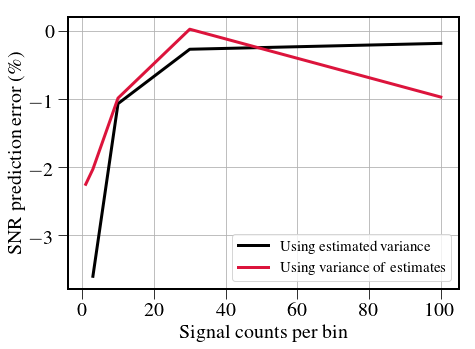

In [43]:
plt.figure(figsize=(7, 5))
print coeff

plt.plot(Slist, (SNR_nonoise-np.sqrt(np.array(Slist)))/SNR_nonoise*100,
         label='Using estimated variance', color='k', lw=3)
plt.plot(Slist, (SNR_nonoise2-np.sqrt(np.array(Slist)))/SNR_nonoise2*100,
         label='Using variance of estimates', color='crimson', lw=3)
print (SNR_nonoise-np.sqrt(np.array(Slist))), SNR_nonoise  # /SNR*100
# plt.plot(Slist,(SNR_comp-np.sqrt(Slist))/SNR_comp*100,label='Using computed variance from trials',color='royalblue',lw=3)
# plt.plot(Slist,np.sqrt(Slist),label='Predicted SNR',color='royalblue',lw=3)

# plt.plot(pxlist,SNR_stat,label='Statistical SNR (%d trials)'%ntrials)
# plt.plot(pxlist,SNRlast,label='Edge of band (%d trials)'%ntrials,color='royalblue',lw=3)
# plt.plot(pxlist,Slist[0]*19./N/(np.sqrt(Slist[0]*19./N+Npix/N*np.array(pxlist))),label='Prediction for middle of band',linestyle='none',marker='o',markersize=10,markerfacecolor='none',color='k')
# plt.plot(pxlist,Slist[0]*19./N/(np.sqrt(Slist[0]*19./N+Npix/N*1.8*np.array(pxlist))),label='Prediction for edge of band',linestyle='none',marker='+',markersize=10,markerfacecolor='none',color='k')
plt.xlabel('Signal counts per bin')
plt.ylabel('SNR prediction error (\%)')
plt.grid('on')
plt.legend()

1.0
3.0
10.0
30.0
100.0


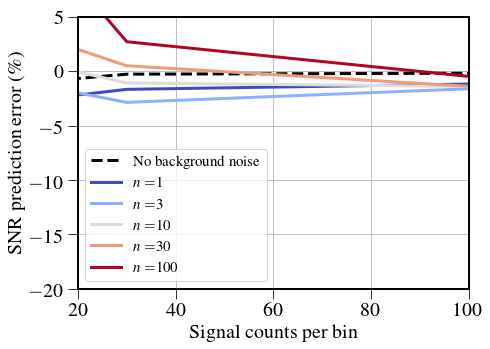

In [44]:
ntrials = 1000
plt.figure(figsize=(7, 5))
# Slist = [100]
cmap = plt.get_cmap('coolwarm')
plt.plot(Slist, (SNR_nonoise-np.sqrt(np.array(Slist)))/SNR_nonoise*100,
         label='No background noise', color='k', lw=3,linestyle='--')

pxlist = [1., 3., 10., 30., 100.]
pxlist = [1., 3., 10., 30., 100.]
for i,pxnoise in enumerate(pxlist):
    SNR_noise = []
    print pxnoise
    for S in Slist:
        vect = np.ones(N)*S*Nbins/N
        lstsq, _, varlstsq, _, _ = SNRcalcBeta(vect, pxnoise, ntrials=ntrials,verbose=False)
        SNR_noise.append(
            np.mean(lstsq[N/2, :, -1])/np.sqrt(np.mean(varlstsq[N/2, :, -1])))
    SNRpred = np.array(Slist)/(np.sqrt(np.array(Slist)+Npix/N*pxnoise))
    plt.plot(Slist, (np.array(SNR_noise)-SNRpred)/SNRpred*100.,
             color=cmap(float(i)/(len(pxlist)-1)),
             label=r'$n=$%d' % pxnoise, lw=3,)
plt.xlabel('Signal counts per bin')
plt.ylabel('SNR prediction error (\%)')
plt.grid('on')
plt.xlim([20,100])
plt.ylim([-20,5])
plt.legend()
plt.savefig('/Users/mrizzo/Downloads/SNRPredictionError.pdf',
            dpi=150, bbox_inches='tight')

In [45]:
print np.mean(varlstsq[N/2, :, -1])
print np.mean(lstsq[N/2, :, -1])

420.23417225769305
99.31083975143366


In [46]:
print Npix/N,Nbins/N
print N
print Npix

3.2205268533075295 1
18
57.96948335953553


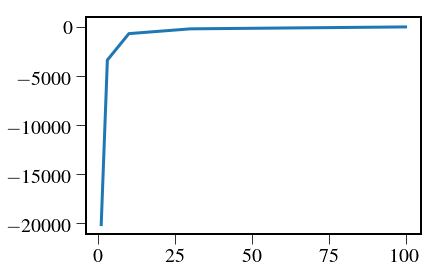

In [47]:
plt.plot(Slist, (np.array(SNR_noise)-np.ones_like(SNR_noise)*S/(np.sqrt(S+Npix/N*pxnoise)))/np.array(SNR_noise)*100.,
         label='%d background counts per pixels' % pxnoise, lw=3)


# Now let's repeat this with the full-PSF extraction

0.018008884


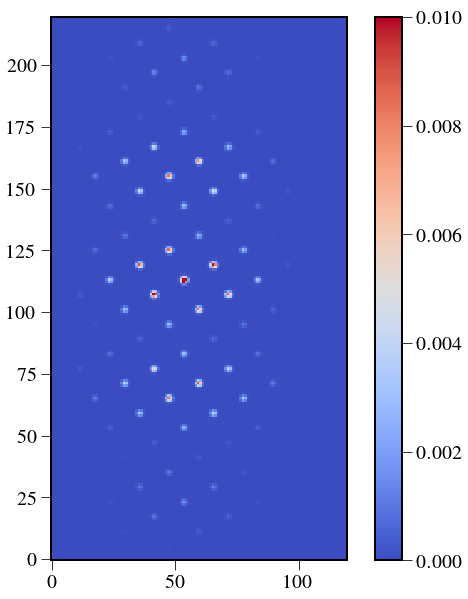

In [48]:
folder = '/Users/mrizzo/IFS/Extraction/'
PSF_polychrome = fits.open(folder+'/PSF_polychrome.fits')[1].data
PSF_polychrome_cut = PSF_polychrome[:, 400:620, 570:690]
PSF = np.zeros_like(PSF_polychrome_cut)
for i in range(PSF.shape[0]):
    PSF[i] = PSF_polychrome_cut[i]/np.sum(PSF_polychrome_cut[i])
print np.amax(PSF[0])
plt.figure(figsize=(10, 10))
plt.imshow(PSF[0], vmin=0.0, vmax=0.01, cmap=cmap)
plt.colorbar()

(-0.5, 34.5, -0.5, 64.5)

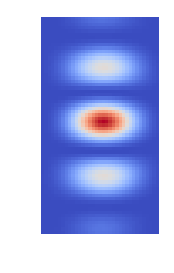

In [49]:
offaxis_psf_filename = '/Users/mrizzo/IFS/OS5/offaxis/spc_offaxis_psf.fits'
offaxis = fits.open(offaxis_psf_filename)[0].data
plt.imshow(offaxis[0, 95:160, 180:215], cmap=cmap)
plt.axis('off')

1.0
114.51614358522592


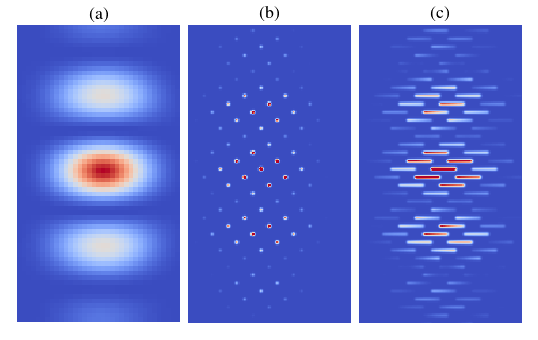

In [50]:
N = PSF.shape[0]
vect = np.ones(N)*100*19./N
tot = np.sum(PSF*vect[:, np.newaxis, np.newaxis], axis=0)
tot /= np.sum(tot)
totpower = np.sum(tot)
print totpower
print 1./np.sum(tot**2)/N
Npix = 1./np.sum(tot**2)
# plt.figure(figsize=(7,15))
# mask = tot<np.amax(tot)/4
# tot[mask]=0
# print np.sum(tot)

# tot/=np.sum(tot)
# print 1./np.sum(tot**2)/N
# plt.imshow(tot,cmap=cmap)
# plt.colorbar()
plt.figure(figsize=(7, 7))
plt.subplot(131)
plt.imshow(offaxis[0, 96:160, 180:215], cmap=cmap)
plt.title('(a)')
plt.axis('off')
import matplotlib.ticker as ticker
plt.gca().xaxis.set_major_locator(ticker.NullLocator())
plt.gca().yaxis.set_major_locator(ticker.NullLocator())

plt.subplot(132)
plt.imshow(PSF[0], vmin=0.0, vmax=0.005, cmap=cmap)
plt.title('(b)')
plt.axis('off')
plt.gca().xaxis.set_major_locator(ticker.NullLocator())
plt.gca().yaxis.set_major_locator(ticker.NullLocator())
plt.subplot(133)
plt.imshow(tot/100, vmax=0.00001, cmap=cmap)
plt.title('(c)')
plt.axis('off')
# plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_axis_off()
plt.margins(0, 0)
import matplotlib.ticker as ticker
# plt.gca().xaxis.set_major_locator(NullLocator())
# plt.gca().yaxis.set_major_locator(NullLocator())
plt.gca().xaxis.set_major_locator(ticker.NullLocator())
plt.gca().yaxis.set_major_locator(ticker.NullLocator())

plt.subplots_adjust(top=1, bottom=0, right=1, left=0,
                    hspace=0, wspace=0.05)
# plt.subplots_adjust(left=0.0,bottom=0.0,top=1.0,wspace=0.05,hspace=0.0)
plt.savefig('/Users/mrizzo/Downloads/FullPSF.pdf',
            dpi=150, bbox_inches='tight', pad_inches=0)

In [51]:
# Slist = [10.,50.,100,200,500,1000,10000]
Slist = [1000]
# pxlist = [1.,10.,50,100,500,1000,2000,3000,4000,5000]
pxlist = [2**p for p in range(5, 10)]
ntrials = 1000
# fig1,ax1 = plt.subplots()
# fig2,ax2 = plt.subplots()
for S in Slist:
    SNR = []
    SNRlast = []
    SNR_stat = []
    betalist = []
    betalast = []
    for pxnoise in pxlist:
        vect = np.ones(N)*S*19./N
        print pxnoise
        lstsq, _, varlstsq, _, beta = SNRcalcBeta(
            vect, pxnoise, ntrials=ntrials, psflets=PSF, Niter=3)
#         ax1.plot(np.mean(beta[:,:,-1],axis=1),label='Pixnoise=%d, S=%d'%(pxnoise,S))
#         ax1.set_ylabel('Number of equivalent noise pixels')
#         ax2.plot(np.mean(lstsq[:,:,-1]/np.sqrt(varlstsq[:,:,-1]),axis=1),label='Pixnoise=%d, S=%d'%(pxnoise,S))
#         ax2.plot(np.sqrt(S))
# #         ax2.errorbar(np.arange(N),np.mean(lstsq[:,:,-1],axis=1),yerr=np.std(lstsq[:,:,-1],axis=1),label='Statistical mean with 1$\sigma$ errors (1000 trials)',color='k',marker='o',linestyle='dashed')
#         ax2.set_ylabel('SNR')
        betalist.append(np.mean(beta[N/2, :, -1]))
        SNR.append(np.mean(lstsq[N/2, :, -1]/np.sqrt(varlstsq[N/2, :, -1])))
        SNR_stat.append(np.mean(lstsq[N/2, :, -1]/np.std(lstsq[N/2, :, -1])))
        betalast.append(np.mean(beta[-1, :, -1]))
        SNRlast.append(np.mean(lstsq[-1, :, -1]/np.sqrt(varlstsq[-1, :, -1])))
# fig1.legend()
# fig2.legend()

32
0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000
64
0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000


KeyboardInterrupt: 

In [ ]:
print SNR, betalist, SNRlast, betalast

In [ ]:
print [2**p for p in range(5, 10)]
print [x**2 for x in range(5, 10)]

In [ ]:
plt.figure(figsize=(7, 5))
plt.plot(pxlist, SNR, label='Middle of band (%d trials)' %
         ntrials, color='crimson', lw=3)
# plt.plot(pxlist,SNR_stat,label='Statistical SNR (%d trials)'%ntrials)
plt.plot(pxlist, SNRlast, label='Edge of band (%d trials)' %
         ntrials, color='royalblue', lw=3)
plt.plot(pxlist, Slist[0]*19./N/(np.sqrt(Slist[0]*19./N+Npix/N*np.array(pxlist))),
         label='Prediction for middle of band', linestyle='none', marker='o', markersize=10, markerfacecolor='none', color='k')
plt.plot(pxlist, Slist[0]*19./N/(np.sqrt(Slist[0]*19./N+Npix/N*1.8*np.array(pxlist))),
         label='Prediction for edge of band', linestyle='none', marker='+', markersize=10, markerfacecolor='none', color='k')
plt.xlabel('Background counts per pixel')
plt.ylabel('SNR per spectral bin')
plt.grid('on')
plt.legend()
plt.savefig('/Users/mrizzo/Downloads/BackgroundPixels_FullPSF.pdf',
            dpi=150, bbox_inches='tight')
print Npix/N

In [ ]:
folder = '/Users/mrizzo/IFS/Extraction/'
planet_cube = fits.getdata(folder+'planet_cube_optext.fits')
subimg = planet_cube[N/2, 40:60, 50:70]
# subimg = planet_cube[N/2]
plt.imshow(subimg,cmap='inferno')
tot = subimg/np.nansum(subimg)
print 1./np.nansum(tot**2)

# Comparison between full forward model and regular matched filter

### Polychrome in full frame

In [ ]:
folder = '/Users/mrizzo/IFS/Extraction/'
cmap='inferno'
PSF_polychrome = fits.open(folder+'/PSF_polychrome.fits')[1].data
# PSF_polychrome_cut = PSF_polychrome[:,400:620,570:690]
PSF_polychrome_cut = PSF_polychrome
PSF = np.zeros_like(PSF_polychrome_cut)
for i in range(PSF.shape[0]):
    PSF[i] = PSF_polychrome_cut[i]/np.sum(PSF_polychrome_cut[i])
print np.amax(PSF[0])
plt.figure(figsize=(10, 10))
plt.imshow(PSF[0], vmin=0.0, vmax=0.01, cmap=cmap)
plt.colorbar()
N = PSF.shape[0]
print N

### Construct the matched filter

In [ ]:
# IWA=3
# OWA=9
# mask,scratch = bowtie(PSF[0],ydim//2-1,xdim//2,openingAngle=65,
#         clocking=-par.philens*180./np.pi,
#         IWApix=IWA*lamc/par.lenslet_wav/par.lenslet_sampling,
#         OWApix=OWA*lamc/par.lenslet_wav/par.lenslet_sampling,
#         export=None,twomasks=False)

# construct_mflib(par,planet_cube=folder+'planet_cube.fits',
#                 threshold=0.2,
#                 lamc=lamc,
#                 BW=BW,
#                 outdir=folder,
#                 mask=mask,
#                 trim=30,
#                 outname = 'mflib.fits.gz',
#                 order=3)
mflib = folder+'mflib.fits.gz'

In [ ]:
planet_cube = fits.getdata(folder+'planet_cube_optext.fits')
mf = np.zeros_like(planet_cube)
psf = np.zeros_like(planet_cube)
for i in range(planet_cube.shape[0]):
    psf[i] = planet_cube[i]/np.nansum(planet_cube[i])
    mf[i] = psf[i]/np.nansum(psf[i]**2)
plt.imshow(mf[N/2])
plt.colorbar()

### Write function that computes SNR from both methods

In [ ]:
from crispy.IFS import reduceIFSMap
from crispy.tools.postprocessing import construct_mflib, convolved_mf


def SNRcompare(vect, pixnoise, ntrials, psflets=PSF, niter=3):
    N = psflets.shape[0]

    lstsq = np.zeros((N, ntrials, niter+1))
    varlstsq = np.zeros((N, ntrials, niter+1))
    lstsqlenslet = np.zeros((N, ntrials))
    varlstsqlenslet = np.zeros((N, ntrials))
    mfiltered = np.zeros((N, ntrials))
    mfcov = np.zeros((N, ntrials))
    Rvect = np.zeros((N, ntrials, niter+1))
    for j in range(ntrials):
        avgimg = np.sum(
            psflets*vect[:, np.newaxis, np.newaxis], axis=0)+pixnoise
        avgimg[avgimg < 0] = 0.0
        pimg = np.random.poisson(avgimg)
        img = pimg-pixnoise
        subim = img[400:620, 570:690]
        sumpix = np.sum(subim)
        subpsflets = psflets[:, 400:620, 570:690]
        lstsq[:, j, 0] = np.ones(N)*sumpix/float(N)
        if j % (max(ntrials/10, 1)) == 0:
            print j, "/", ntrials
        for i in range(niter):
            prev = lstsq[:, j, i]
            variance = np.reshape(
                np.sum(subpsflets*prev[:, np.newaxis, np.newaxis], axis=0)+pixnoise, -1)
            Ninv = np.diag(1./(variance+1e-10))
            psflets_flat = np.reshape(subpsflets, (subpsflets.shape[0], -1))
            A = psflets_flat.T
            Cinv = np.dot(A.T, np.dot(Ninv, A))
            C = np.linalg.inv(Cinv)
            Q = sp.linalg.sqrtm(Cinv)
            s = np.sum(Q, axis=0)
            R = Q/s[:, np.newaxis]
            x = np.reshape(subim, -1)
            varlstsq[:, j, i+1] = 1./(s**2+1e-10)
            right = np.dot(A.T, np.dot(Ninv, x))
            f = np.dot(C, right)
            lstsq[:, j, i+1] = np.dot(R, f)
            Rvect[:, j, i+1] = np.dot(R, vect)

        # Now extract into cube
        cubeout = reduceIFSMap(par, img.astype(float), method='lstsq_conv', smoothbad=False,
                               fitbkgnd=False, niter=niter, pixnoise=pixnoise, normpsflets=True)
        # Apply matched filter to data and variance
#         convolved = convolved_mf(cubeout.data,mflib)
#         convvar = convolved_mf(1./(cubeout.ivar+1e-10),mflib)
        # Find peak
#         yp,xp = np.unravel_index(np.nanargmax(convolved[N//2]), convolved[N//2].shape)
#         mfiltered[:,j] = convolved[:,yp,xp]
#         mfcov[:,j] = convvar[:,yp,xp]
        for k in range(N):
            mfiltered[k, j] = np.nansum(cubeout.data[k]*mf[k])
            mfcov[k, j] = np.nansum((1./cubeout.ivar[k])*mf[k]**2)
#             guess = np.nansum(cubeout.data[k]*mf[k])
#             #variance = np.reshape(1./(cubeout.ivar[k]+1e-10),-1)
#             Ninv = np.diag(np.reshape(cubeout.ivar[k],-1))
#             psfs_flat = np.reshape(psf[k], -1)
#             A = psfs_flat.T
#             Cinv = np.dot(A.T,np.dot(Ninv,A))
#             Cinv =
#             C = np.linalg.inv(Cinv)
#             x = np.reshape(cubeout.data[k],-1)
#             right = np.dot(A.T,np.dot(Ninv,x))
#             lstsqlenslet[k,j] = np.dot(C,right)
#             varlstsqlenslet[k,j] = C

    # ,lstsqlenslet,varlstsqlenslet
    return lstsq[:, :, -1], varlstsq[:, :, -1], mfiltered, mfcov, cubeout

In [ ]:
# Ninv = np.diag(np.reshape(cubeout.ivar[N/2],-1))
# psfs_flat = np.reshape(psf[N/2], -1)
# A = psfs_flat.T
# Cinv = np.dot(A.T,np.dot(Ninv,A))
# Cinv= np.nansum(psfs_flat**2*Ninv)
# print np.sqrt(1./Cinv)
print np.nansum(mf[N/2]**2), np.nansum(mf[N/2])
print mf[N/2, 51, 62], mf[N/2, 51, 62]**2
print np.sqrt(np.nansum(cubeout.data[N/2]*mf[N/2])+114*100)
print

In [ ]:
print cubeout.data[N/2, 50, 61], np.sqrt(1./cubeout.ivar[N/2, 50, 61])

In [ ]:
N = PSF.shape[0]
S = 500
pixnoise = 1000
vect = np.ones(N)*S*Nbins./N
ntrials = 1
lstsq, varlstsq, mfiltered, mfcov, cubeout = SNRcompare(
    vect, pixnoise, ntrials)

In [ ]:
plt.plot(mfiltered/np.sqrt(mfcov))
plt.plot(lstsq/np.sqrt(varlstsq))
print np.nansum(cubeout.data[N/2])

In [ ]:
plt.plot(lstsq)
plt.plot(mfiltered)

In [ ]:
plt.plot(np.sqrt(mfcov))
plt.plot(np.sqrt(varlstsq))

In [ ]:
plt.imshow(1./np.sqrt(cubeout.ivar[N/2, 40:60, 50:70]))
plt.colorbar()

In [ ]:
plt.imshow(cubeout.data[N/2, 40:60, 50:70])
plt.colorbar()

In [ ]:
print lstsq, mfiltered

In [ ]:
N = PSF.shape[0]
S = 1000
pixnoise = 100
vect = np.ones(N)*S*19./N
ntrials = 50
lstsq, varlstsq, mfiltered, mfcov, cubeout = SNRcompare(
    vect, pixnoise, ntrials)

In [ ]:
plt.plot(np.std(lstsq, axis=1))
plt.plot(np.std(mfiltered, axis=1))
plt.plot(np.sqrt(varlstsq[:, -1]))

In [ ]:
np.mean(lstsq-mfiltered, axis=1)

In [ ]:
plt.plot(lstsq-mfiltered)

In [ ]:
np.sqrt(np.nansum((1./(cubeout.ivar[N/2]))*mf[N/2]))

In [ ]:
from crispy.IFS import reduceIFSMap
from crispy.tools.postprocessing import construct_mflib, convolved_mf
N = PSF.shape[0]
S = 10000
pixnoise = 100
vect = np.ones(N)*S*19./N
pimg = np.random.poisson(
    np.sum(PSF*vect[:, np.newaxis, np.newaxis], axis=0)+pixnoise)
img = (pimg-pixnoise).astype(float)
cubeout = reduceIFSMap(par, img, method='lstsq_conv',
                       smoothbad=False, fitbkgnd=False, niter=3, pixnoise=pixnoise)

In [ ]:
plt.imshow(1./np.sqrt(cubeout.ivar[N/2, 40:60, 50:70]))
plt.colorbar()  # print(np.sqrt(1./cubeout.ivar[N/2,40:60,50:70]))
# print(cubeout.data[N/2,40:60,50:70])
plt.figure()
plt.imshow(cubeout.data[N/2, 40:60, 50:70] *
           np.sqrt(cubeout.ivar[N/2, 40:60, 50:70]))
plt.colorbar()
plt.figure()
plt.imshow(cubeout.data[N/2, 40:60, 50:70])
plt.colorbar()
plt.figure()
plt.plot(cubeout.data[:, 50, 61]*np.sqrt(cubeout.ivar[:, 50, 61]))

# Show end-to-end spectral extraction

In [ ]:
from scipy import ndimage
from crispy.tools.inputScene import calc_contrast
from crispy.IFS import polychromeIFS
from crispy.tools.image import Image
os.chdir('/Users/mrizzo/IFS/crispy/crispy/WFIRST/')
from params import Params
par = Params()
print par.wavecalDir

bg = 10


In [ ]:
from crispy.IFS import reduceIFSMap


In [ ]:
def interp(data,new_wavel):
    nl,nx,ny = data.shape
    x = np.arange(nx)
    y = np.arange(ny)
    l = (new_wavel-np.amin(new_wavel))*(nl-1)/(np.amax(new_wavel)-np.amin(new_wavel))
    l,x,y = np.meshgrid(l,x,y)
    newpsf = ndimage.map_coordinates(data,[l,x,y],prefilter=False,mode='nearest',order=1)
    return np.swapaxes(newpsf,0,1)

In [ ]:
from crispy.tools.image import Image
from crispy.IFS import polychromeIFS
spc_psf_path = '/Users/mrizzo/IFS/OS6/SPC/spc_os6/'
new_wavel = np.linspace(0.7,0.84,25)
planetpsf_roll2 = fits.getdata(spc_psf_path+'planet_psfs/os6_spc_770nm_psf_3.41_0.79.fits')
roll2 = interp(planetpsf_roll2,new_wavel)
psf_roll2 = Image(data=roll2)
psf_roll2.header['LAM_C'] = 0.77
psf_roll2.header['PIXSIZE'] = 0.1
offaxis_roll2 = polychromeIFS(par,new_wavel*1000,psf_roll2,QE=False)


In [ ]:
dat = np.random.poisson(offaxis_roll2*1000+bg)
plt.imshow(dat[400:620,580:730])
plt.colorbar()

In [ ]:
IFSmap = np.zeros((1024,1024))
IFSmap = dat.astype(np.float)-bg
refIFS = reduceIFSMap(par,IFSmap,name='test_extract',
                        method='lstsq_conv',
                        smoothbad=False,
                        pixnoise=bg,
                        fitbkgnd=False,
                        medsub=False,
                        gain=1.0,
                        niter=5
                       )


In [ ]:
print par.wavecalDir


## Make filter to smooth edges

In [ ]:
minlam = 700./1000.
maxlam = 840./1000.
clam = 770./1000.
hw = 68./1000.
exponent = 30.
new_wavel = np.linspace(0.7,0.84,25)
print new_wavel
f = np.exp(-((new_wavel-clam)/hw)**exponent)

## Propagate reference to get matched filter

In [ ]:
from crispy.tools.inputScene import calc_contrast
spc_psf_path = '/Users/mrizzo/IFS/OS6/SPC/spc_os6/'

planetpsf_roll = fits.getdata(spc_psf_path+'planet_psfs/os6_spc_770nm_psf_4.80_0.00.fits')
planetroll = interp(planetpsf_roll,new_wavel)
contrast = calc_contrast(new_wavel*1000,1.5,1,par.codeRoot +'/Inputs/Jupiter_1x_5AU_90deg.dat').value
# psf_roll = Image(data=planetroll*contrast[:,np.newaxis,np.newaxis]*f[:,np.newaxis,np.newaxis])
psf_roll = Image(data=planetroll*f[:,np.newaxis,np.newaxis])
psf_roll.header['LAM_C'] = 0.77
psf_roll.header['PIXSIZE'] = 0.1
offaxis_roll = polychromeIFS(par,new_wavel*1000,psf_roll,QE=False)


In [ ]:
fits.writeto(par.exportDir+'/test_mf.fits',offaxis_roll,overwrite=True)

## Extract reference to get matched filter

In [ ]:
IFSmap = offaxis_roll.astype(np.float)
refIFS = reduceIFSMap(par,IFSmap,name='test_extract_mf',
                        method='lstsq_conv',
                        smoothbad=False,
                        pixnoise=0,
                        fitbkgnd=False,
                        medsub=False,
                        gain=1.0,
                        niter=3
                       )

## Make Matched filter

In [ ]:
from crispy.tools.imgtools import bowtie

ydim,xdim=refIFS.data[0].shape
lamc=770.
IWA = 2.8
OWA=9.
mask, scratch = bowtie(refIFS.data[0], ydim //
                       2 -
                       1, xdim //
                       2, openingAngle=65, clocking=-
                       par.philens *
                       180. /
                       np.pi, IWApix=IWA *
                       lamc /
                       par.lenslet_wav /
                       par.lenslet_sampling, OWApix=OWA *
                       lamc /
                       par.lenslet_wav /
                       par.lenslet_sampling, export=None, twomasks=False)
plt.figure(figsize=(7,5))
plt.title('Inspect average')
plt.imshow(refIFS.data[0]*mask,cmap=cmap)
plt.colorbar(orientation='horizontal',fraction=0.046, pad=0.04)


In [ ]:
from crispy.tools.postprocessing import mf

mfref = mf(refIFS,mask,0.0)
fits.writeto('/Users/mrizzo/Downloads/mf.fits',mfref,overwrite=True)

In [ ]:
spectrum = np.nansum(np.nansum(refIFS.data*mfref,axis=2),axis=1)
plt.plot(spectrum)
# plt.plot(np.nansum(np.nansum(psf_roll.data,axis=2),axis=1))

## Produce image with some contrast curve

In [ ]:
from crispy.tools.inputScene import calc_contrast
planetpsf_roll = fits.getdata(spc_psf_path+'planet_psfs/os6_spc_770nm_psf_4.80_0.00.fits')
planetroll = interp(planetpsf_roll,new_wavel)
contrast = calc_contrast(new_wavel*1000,1.5,1,par.codeRoot +'/Inputs/Jupiter_1x_5AU_90deg.dat').value
psf_contrast = Image(data=planetroll*contrast[:,np.newaxis,np.newaxis]*f[:,np.newaxis,np.newaxis])
psf_contrast.header['LAM_C'] = 0.77
psf_contrast.header['PIXSIZE'] = 0.1
offaxis_contrast = polychromeIFS(par,new_wavel*1000,psf_contrast,QE=False)


In [ ]:
plt.plot(new_wavel,np.sum(np.sum(psf_contrast.data,axis=2),axis=1))
plt.plot(new_wavel,contrast*0.14)
plt.xlabel('Wavelength (nm)')

## Create noisy image

In [ ]:
bg=10
dat = np.random.poisson(offaxis_contrast*0.7e11+bg)
plt.imshow(dat[400:620,580:730],cmap=cmap)
plt.colorbar()

In [ ]:
IFSmap = dat.astype(np.float)-bg
IFS_contrast = reduceIFSMap(par,IFSmap,name='test_extract_albedo',
                        method='lstsq_conv',
                        smoothbad=False,
                        pixnoise=bg,
                        fitbkgnd=False,
                        medsub=False,
                        gain=1.0,
                        niter=3
                       )

In [ ]:
spectrum_contrast = np.nansum(np.nansum(IFS_contrast.data*mfref,axis=2),axis=1)
from crispy.tools.reduction import calculateWaveList
lam_midpts,_ = calculateWaveList(par)
print lam_midpts,new_wavel
plt.plot(lam_midpts,spectrum_contrast/spectrum*np.amax(contrast)/np.amax(spectrum_contrast/spectrum))
plt.plot(new_wavel*1000,contrast)


In [ ]:
from scipy import ndimage
from scipy.interpolate import interp1d
smooth = ndimage.filters.gaussian_filter1d(contrast, 25./18., order=0, mode='nearest')
smoothfunc = interp1d(new_wavel*1000, smooth,fill_value='extrapolate')

var = np.nansum(np.nansum(1./IFS_contrast.ivar*mfref**2,axis=2),axis=1)
normspec = spectrum_contrast/spectrum*np.amax(contrast)/np.amax(spectrum_contrast/spectrum)
normvar = var/spectrum**2*np.amax(contrast)**2
normvar /= np.amax(spectrum_contrast/spectrum)**2
plt.errorbar(lam_midpts,normspec,yerr = np.sqrt(normvar))
plt.plot(new_wavel*1000,contrast)
plt.plot(lam_midpts,smoothfunc(lam_midpts))
print len(new_wavel)

## Extract in a loop

In [ ]:
from IPython.display import clear_output
Ntrials = 100
spec_list = []
var_list = []
specnorm_list = []
varnorm_list = []
for i in range(Ntrials):
    if i % (max(Ntrials/10, 1)) == 0: 
        clear_output()
        print i
    dat = np.random.poisson(offaxis_contrast*0.7e11+bg)-bg
    IFSmap = dat.astype(np.float)
    IFS_contrast = reduceIFSMap(par,IFSmap,name='test_extract_albedo',
                                method='lstsq_conv',
                                smoothbad=False,
                                pixnoise=bg,
                                fitbkgnd=False,
                                medsub=False,
                                gain=1.0,
                                niter=3)
    spectrum_contrast = np.nansum(np.nansum(IFS_contrast.data*mfref,axis=2),axis=1)
    var = np.nansum(np.nansum(1./IFS_contrast.ivar*mfref**2,axis=2),axis=1)
    normspec = spectrum_contrast/spectrum*np.amax(contrast)/np.amax(spectrum_contrast/spectrum)
    normvar = var/spectrum**2*np.amax(contrast)**2
    normvar /= np.amax(spectrum_contrast/spectrum)**2

    spec_list.append(spectrum_contrast)
    var_list.append(var)
    specnorm_list.append(normspec)
    varnorm_list.append(normvar)
    

In [ ]:
spec_arr = np.array(spec_list)
var_arr = np.array(var_list)
specnorm_arr = np.array(specnorm_list)
varnorm_arr = np.array(varnorm_list)
print spec_arr.shape

In [ ]:
from scipy import ndimage
from scipy.interpolate import interp1d
smooth = ndimage.filters.gaussian_filter1d(contrast, 25./18., order=0, mode='nearest')
smoothfunc = interp1d(new_wavel*1000, smooth,fill_value='extrapolate')

plt.errorbar(lam_midpts,np.mean(specnorm_arr,axis=0),yerr = np.std(specnorm_arr,axis=0))
plt.errorbar(lam_midpts,np.mean(specnorm_arr,axis=0),yerr = np.sqrt(np.mean(varnorm_arr,axis=0)),color='k')
plt.plot(new_wavel*1000,contrast)
plt.plot(lam_midpts,smoothfunc(lam_midpts))
print len(new_wavel)

In [ ]:
plt.plot(np.sqrt(np.mean(var_arr,axis=0)))
plt.plot(np.std(spec_arr,axis=0))

In [ ]:
maxspec = np.amax(np.mean(spec_arr/spectrum[np.newaxis,:],axis=0))
nspec = spec_arr*np.amax(contrast)/maxspec/spectrum[np.newaxis,:]
nvar = var_arr*(np.amax(contrast)/maxspec/spectrum[np.newaxis,:])**2
plt.plot(np.sqrt(np.mean(nvar,axis=0)))
plt.plot(np.std(nspec,axis=0))

#     normspec = spectrum_contrast/spectrum*np.amax(contrast)/np.amax(spectrum_contrast/spectrum)
#     normvar = var/spectrum**2*np.amax(contrast)**2
#     normvar /= np.amax(spectrum_contrast/spectrum)**2


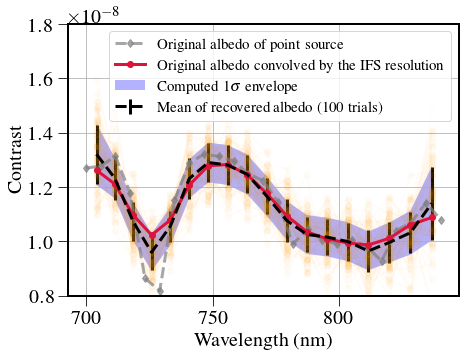

In [102]:
plt.figure(figsize=(7,5))
plt.plot(lam_midpts,nspec.T, color='gray', alpha=0.03, marker='o')
plt.fill_between(lam_midpts, np.mean(nspec, axis=0)-np.sqrt(np.mean(nvar,axis=0)), 
                 np.mean(nspec, axis=0)+np.sqrt(np.mean(nvar,axis=0)), 
                 alpha=0.3, facecolor='blue', label='Computed 1$\sigma$ envelope')
# plt.errorbar(lam_midpts,np.mean(nspec,axis=0),yerr = np.sqrt(np.mean(nvar,axis=0)),color='k')
plt.plot(new_wavel*1000,contrast,lw=3,color='gray',linestyle='--',
         alpha=0.7,label='Original albedo of point source',marker='d',markersize=20)
plt.plot(lam_midpts,smoothfunc(lam_midpts),lw=3,color='crimson',marker='o',label='Original albedo convolved by the IFS resolution')
plt.errorbar(lam_midpts,np.mean(nspec,axis=0),yerr = np.std(nspec,axis=0),lw=3,color='k',linestyle='--',label=r'Mean of recovered albedo (100 trials)')


# plt.plot(lam_midpts, lstsq, color='gray', alpha=0.01, marker='o')
# plt.plot(lam_midpts, lstsq[:, -2], '-o',
#          color='crimson', lw=3, label='Single realization')
# plt.fill_between(lam_midpts, np.mean(lstsq, axis=1)-np.sqrt(varlstsq[:, -1]), np.mean(
#     lstsq, axis=1)+np.sqrt(varlstsq[:, -1]), alpha=0.3, facecolor='blue', label='Computed 1$\sigma$ envelope')
# plt.errorbar(lam_midpts, np.mean(lstsq, axis=1), yerr=np.std(lstsq, axis=1),
#              label='Statistical mean with 1$\sigma$ errors (1000 trials)', color='k', marker='o', linestyle='dashed')
plt.ylim([0.8e-8,1.8e-8])
plt.legend(fontsize=15)
plt.grid('on')
plt.ylabel('Contrast')
plt.xlabel(r'Wavelength (nm)')
plt.savefig('/Users/mrizzo/Downloads/Spectral_Extraction_PSF.pdf',
            dpi=150, bbox_inches='tight')

In [72]:
chisqlist = []
for i in range(nspec.shape[0]):
    chisqlist.append(np.sum((smoothfunc(lam_midpts) - nspec[i,:])**2/nvar[i,:])/18.)
chisqlist = np.array(chisqlist)
print np.mean(chisqlist),np.std(chisqlist)

1.55718533769 0.515346368084


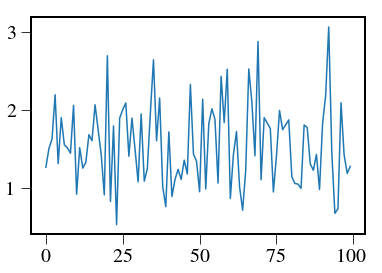

In [73]:
plt.plot(chisqlist)

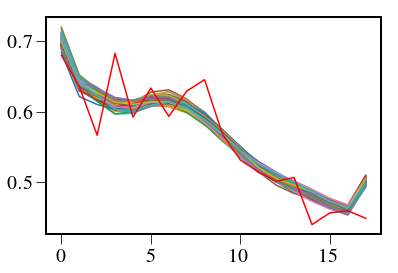

In [74]:
for i in range(Ntrials):
    plt.plot(np.sqrt(var_arr[i]))
plt.plot(np.std(spec_arr,axis=0),color='red')

In [75]:
IFSmap.shape

(1024, 1024)

In [76]:
orig = IFSmap[400:620,580:730]
model = fits.getdata(par.exportDir+'/test_extract_albedo_red_lstsq_conv_model.fits')[400:620,580:730]
resid = fits.getdata(par.exportDir+'/test_extract_albedo_red_lstsq_conv_resid.fits')[400:620,580:730]
chisq = fits.getdata(par.exportDir+'/test_extract_albedo_red_lstsq_conv_chisq.fits')

In [77]:
print np.nanmean(chisq),np.nanstd(chisq)

0.922523 0.114745


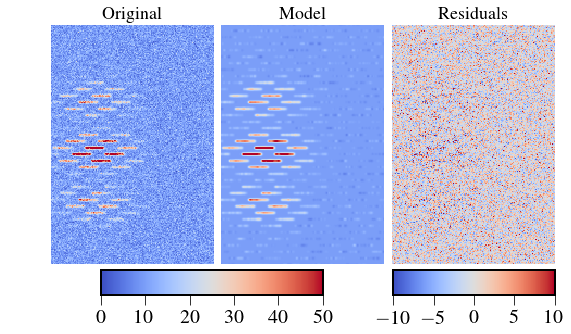

In [78]:
fig, axarr = plt.subplots(1,3, figsize=(7, 7))
im = axarr[0].imshow(orig+bg, vmin=0,vmax=50,cmap=cmap)
axarr[0].set_title('Original')
axarr[0].axis('off')
# import matplotlib.ticker as ticker
# axarr[0].xaxis.set_major_locator(ticker.NullLocator())
# axarr[0].yaxis.set_major_locator(ticker.NullLocator())

axarr[1].imshow(model+bg,vmin=0,vmax=50, cmap=cmap)
axarr[1].set_title('Model')
axarr[1].axis('off')
# axarr[1].xaxis.set_major_locator(ticker.NullLocator())
# axarr[1].yaxis.set_major_locator(ticker.NullLocator())

im2 = axarr[2].imshow(resid, vmin=-10,vmax=10,cmap='coolwarm')
axarr[2].set_title('Residuals')
axarr[2].axis('off')
# plt.colorbar(fraction=0.046, pad=0.04)
# import matplotlib.ticker as ticker
# plt.gca().xaxis.set_major_locator(NullLocator())
# plt.gca().yaxis.set_major_locator(NullLocator())
# plt.gca().xaxis.set_major_locator(ticker.NullLocator())
# plt.gca().yaxis.set_major_locator(ticker.NullLocator())

fig.subplots_adjust(top=0.98, bottom=0, right=1, left=0.,
                    hspace=0, wspace=0.05)

cbar_ax = fig.add_axes([0.1, 0.19, 0.44, 0.05])
fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar_ax.tick_params(labelsize=20) 
cbar_ax = fig.add_axes([0.68, 0.19, 0.32, 0.05])
cbar_ax.tick_params(labelsize=20)

# cbar_ax.set_xticks([-15,0,10])
fig.colorbar(im2, cax=cbar_ax, orientation='horizontal',ticks=[-10, -5, 0, 5, 10])


# plt.subplots_adjust(left=0.0,bottom=0.0,top=1.0,wspace=0.05,hspace=0.0)
plt.savefig('/Users/mrizzo/Downloads/exampleSPC_PSF.pdf',
            dpi=150, bbox_inches='tight', pad_inches=0)

## Attempt extracting with matched filters at different thresholds

(18, 108, 108)
30.4854721775


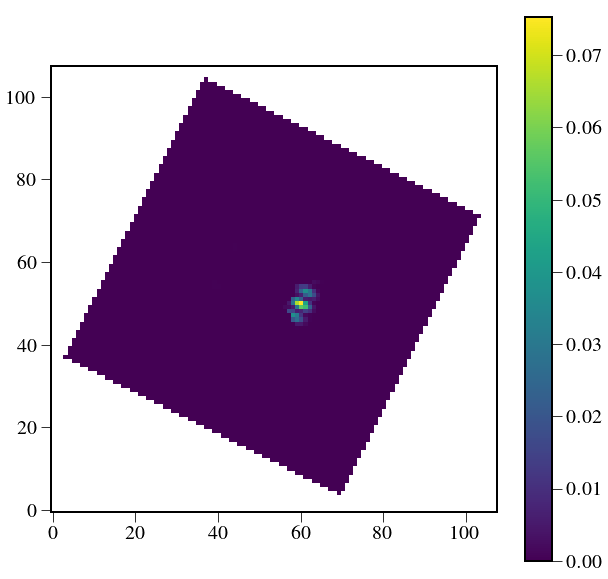

In [79]:
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99]
print mfref.shape
psf = refIFS.data*mask[np.newaxis,:,:]
psfslice = psf[0]/np.nansum(psf[0])
print 1./np.nansum(psfslice**2)
plt.figure(figsize=(10,10))
plt.imshow(psfslice)
plt.colorbar()

In [80]:
def beta(cube,mask, threshold):
    noiseEqPix = np.zeros(cube.data.shape[0])
    for slicenum in range(cube.data.shape[0]):
        cube_norm = cube.data[slicenum] / np.nansum(cube.data[slicenum])
        msk = mask * (cube_norm > np.nanmax(cube_norm) * threshold)

        # zero out all pixels outside of the thresholded area
        cube_norm[~msk] = 0.0

        # normalize
        cube_norm /= np.nansum(cube_norm)

        # this is now the final matched filter coefficients
        noiseEqPix[slicenum] = 1. / np.nansum(cube_norm**2)
    return noiseEqPix

def npix(cube,mask, threshold):
    npix = np.zeros(cube.data.shape[0])
    for slicenum in range(cube.data.shape[0]):
        cube_norm = cube.data[slicenum] / np.nansum(cube.data[slicenum])
        msk = mask * (cube_norm > np.nanmax(cube_norm) * threshold)
        # this is now the final matched filter coefficients
        npix[slicenum] = np.sum(msk)
    return npix


def fluxfrac(cube,mask,threshold):
    fracPSF = np.zeros(cube.data.shape[0])
    for slicenum in range(cube.data.shape[0]):
        cube_norm = cube.data[slicenum] / np.nansum(cube.data[slicenum])
        msk = mask * (cube_norm > np.nanmax(cube_norm) * threshold)

        # zero out all pixels outside of the thresholded area
        cube_norm[~msk] = 0.0
        
        # measure new flux
        fracPSF[slicenum] = np.nansum(cube_norm)

    return fracPSF

In [81]:
print beta(refIFS,mask,0.5)
print fluxfrac(refIFS,mask,0.5)
print npix(refIFS,mask,0.99)


[ 4.82645029  4.83282907  4.84090463  4.84900737  4.85755396  4.8651631
  4.87296311  4.88007737  4.88727622  5.74798906  5.75629879  5.76400169
  5.77144735  5.77838459  5.78510568  5.79110019  5.79614951  6.65893148]
[ 0.26387566  0.26228334  0.26028477  0.25800855  0.25562722  0.25321128
  0.25074263  0.24824759  0.24570639  0.27315062  0.27030906  0.26745158
  0.26456972  0.26165314  0.25870688  0.25579322  0.25323237  0.27782535]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


In [82]:
betas = []
fracs = []
npixs = []
slicenum = 9
for t in thresholds:
    betas.append(beta(refIFS,mask,t)[slicenum])
    fracs.append(fluxfrac(refIFS,mask,t)[slicenum])
    npixs.append(npix(refIFS,mask,t)[slicenum])



Text(0,0.5,u'Normalized ratio')

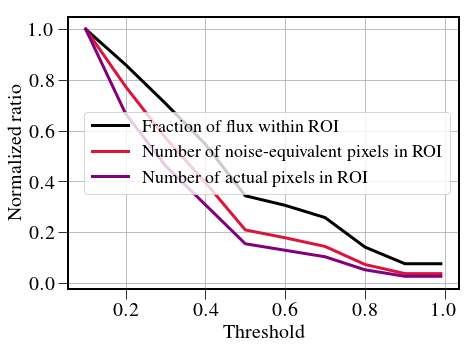

In [83]:
plt.figure(figsize=(7,5))
plt.plot(thresholds,fracs/fracs[0],label='Fraction of flux within ROI',color='k',lw=3)
plt.plot(thresholds,betas/betas[0],label='Number of noise-equivalent pixels in ROI',color='crimson',lw=3)
plt.plot(thresholds,npixs/npixs[0],label='Number of actual pixels in ROI',color='purple',lw=3)
plt.grid('on')
plt.xlabel('Threshold')
plt.legend(fontsize=18)
plt.ylabel('Normalized ratio')

Text(0,0.5,u'Number of pixels in ROI')

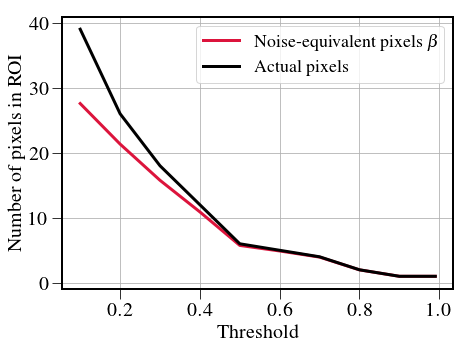

In [84]:
plt.figure(figsize=(7,5))
plt.plot(thresholds,betas,label=r'Noise-equivalent pixels $\beta$',color='crimson',lw=3)
plt.plot(thresholds,npixs,label='Actual pixels',color='k',lw=3)
plt.grid('on')
plt.xlabel('Threshold')
plt.legend(fontsize=18)
plt.ylabel('Number of pixels in ROI')

In [85]:
betas,npixs

([27.56978679381433,
  21.33424010756011,
  15.764512027177251,
  10.900876027305623,
  5.7479890622980214,
  4.8938932130289814,
  3.9521598821680222,
  1.9908874262064424,
  1.0,
  1.0],
 [39.0, 26.0, 18.0, 12.0, 6.0, 5.0, 4.0, 2.0, 1.0, 1.0])

### SNR as function of thresholds

(10, 18)


Text(0,0.5,u'SNR')

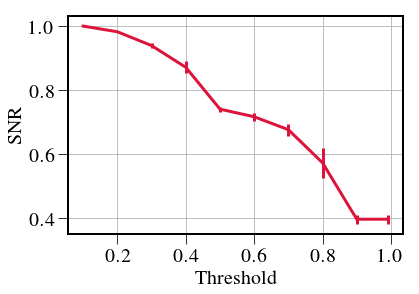

In [86]:
S=10
n=100
snrlist = []
# slicenum = -1
for slicenum in range(len(refIFS.data)):
    snr = []
    for t in thresholds:
        b = beta(refIFS,mask,t)[slicenum]
        f = fluxfrac(refIFS,mask,t)[slicenum]
        snr.append(S*f/np.sqrt(S*f+b*n))
    snrlist.append(snr/snr[0])

snrlist = np.array(snrlist).T
print snrlist.shape

plt.errorbar(thresholds,np.mean(snrlist,axis=1),lw=3,color='crimson',yerr = np.std(snrlist,axis=1))
plt.grid('on')
plt.xlabel('Threshold')
plt.legend(fontsize=18)
plt.ylabel('SNR')

### Verification of Gaussian PRF number of pixels

Sharpness method from Mighell (2005):  7.22915917894
Th. value from Mighell (2005) for Gaussian PRF:  6.15752160104


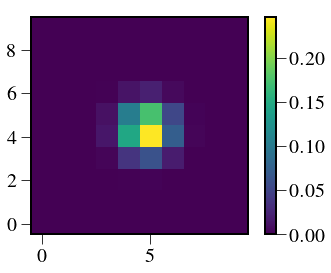

In [87]:
from scipy.special import erf
size=10
_x = np.arange(size) - size // 2+0.2
_y = np.arange(size) - size // 2+0.7
_x, _y = np.meshgrid(_x, _y)
sigma = 0.7

psflet = (erf((_x + 0.5) / (np.sqrt(2) * sigma)) -
          erf((_x - 0.5) / (np.sqrt(2) * sigma))) * \
    (erf((_y + 0.5) / (np.sqrt(2) * sigma)) -
     erf((_y - 0.5) / (np.sqrt(2) * sigma)))
# psflet = np.exp(-(_x**2+_y**2)/2./sigma**2)/sigma/np.sqrt(2.*np.pi)

psflet /= np.nansum(psflet)
plt.imshow(psflet)
plt.colorbar()
print "Sharpness method from Mighell (2005): ",1./np.nansum(psflet**2)
print "Th. value from Mighell (2005) for Gaussian PRF: ",4*np.pi*sigma**2

# Some additional paper plots

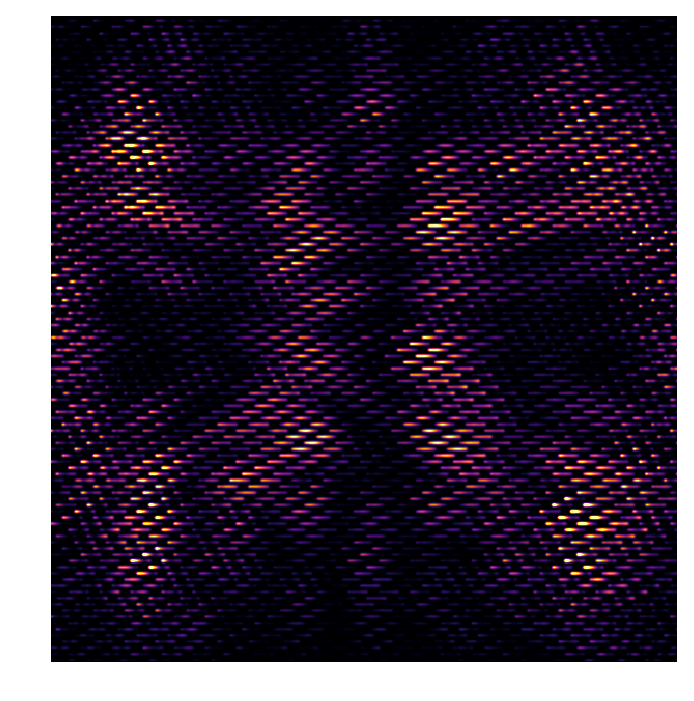

In [88]:
fname = '/Users/mrizzo/IFS/OS6/SPC/IFSraw/os6_60.fits'
img = fits.open(fname)[0].data
plt.figure(figsize=(10,10))
plt.imshow(np.sqrt(img[200:-200,220:-200]+1e-4),vmax=0.025,cmap='inferno')
plt.axis('off')
plt.tight_layout()
# plt.colorbar(fraction=0.046, pad=0.04)
plt.savefig('/Users/mrizzo/Downloads/SPC.pdf',
            dpi=150, bbox_inches='tight')

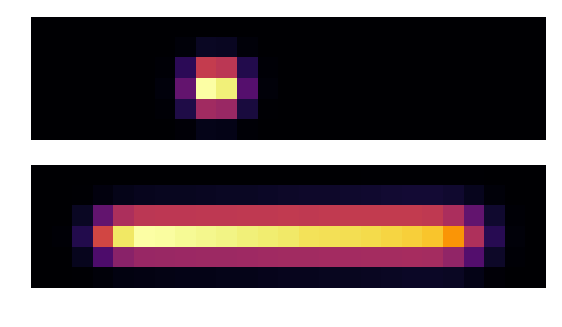

In [89]:
plt.figure(figsize=(10,5))
plt.subplot(211)
plt.imshow(psflet_subarr[5],cmap='inferno')
plt.axis('off')
plt.subplot(212)
vect = np.ones(len(psflet_subarr))
pimg = np.sum(psflet_subarr*vect[:, np.newaxis, np.newaxis], axis=0)
plt.imshow(pimg,cmap='inferno')
plt.axis('off')

plt.subplots_adjust(wspace=0.05)

# plt.colorbar(fraction=0.046, pad=0.04)
plt.savefig('/Users/mrizzo/Downloads/PSFlet_Microspec.pdf',
            dpi=150, bbox_inches='tight')